In [1]:
def get_mesh_center(mesh_bounds):
    centerX = (mesh_bounds[1] + mesh_bounds[0]) / 2
    centerY = (mesh_bounds[3] + mesh_bounds[2]) / 2
    centerZ = (mesh_bounds[5] + mesh_bounds[4]) / 2
    
    return [centerX, centerY, centerZ]

In [2]:
from matplotlib.colors import LinearSegmentedColormap
import numpy as np

def get_cmap_fro_range(scalar_range: np.ndarray, n_divs: int) -> LinearSegmentedColormap:
    full_colors = ['#062544', '#03619F', '#00A3D6', '#01A781', '#2ABC29', '#CDECAF', "#FFF585", "#FFF22A", "#FEA500", "#F60100", "#A70012", "#510007"]
    N = len(full_colors)
    
    if np.all(scalar_range <= 0):
        hex_colors = full_colors[:5]
    elif np.all(scalar_range >= 0):
        hex_colors = full_colors[6:]
    elif np.abs(scalar_range.min()) > np.abs(scalar_range.max()):
        delta = (scalar_range.max() - scalar_range.min()) / N
        n_min = round(-scalar_range.min() / delta - 0.5)
        n_max = N - 1 - n_min
        hex_colors = full_colors[:6 + n_max]
    elif np.abs(scalar_range.min()) < np.abs(scalar_range.max()):
        delta = (scalar_range.max() - scalar_range.min()) / N
        n_max = round(scalar_range.max() / delta - 0.5)
        n_min = N - 1 - n_max
        hex_colors = full_colors[7 - n_min:]
    else:
        hex_colors = full_colors

    rgb_colors = [tuple(int(color.lstrip('#')[i:i+2], 16) / 255 for i in (0, 2, 4)) for color in hex_colors]

    custom_cmap = LinearSegmentedColormap.from_list('custom_colormap', rgb_colors, N=n_divs)
    
    return custom_cmap
    

In [3]:
from PIL import Image

def crop_image_center(image_path, width_ratio, height_ratio):
    # Open the image using Pillow
    original_image = Image.open(image_path)

    # Get the original width and height
    original_width, original_height = original_image.size

    # Calculate the crop box based on percentages and center
    crop_width = original_width * width_ratio
    crop_height = original_height * height_ratio

    left = (original_width - crop_width) / 2
    top = (original_height - crop_height) / 2
    right = (original_width + crop_width) / 2
    bottom = (original_height + crop_height) / 2

    # Crop the image
    cropped_image = original_image.crop((left, top, right, bottom))

    return cropped_image

In [4]:
projections = {
    "x_plus": [0,-90,0],
    "x_minus": [0,90,0],
    "y_plus": [-90,0,0],
    "y_minus": [90,0,0],
}

COLORMAP_N_DIVS = 10
OFFSET_VALUE = 15

In [5]:
file_info = {
    "Ce_5x5.vtp": ["Ce_mean_qs", "Ce_xtr_min", "Ce_xtr_max"],
    "Ce_25x25.vtp": ["Ce_xtr_min", "Ce_xtr_max"],
    "Cf.vtp": ["Cfz_xtr_min", "Cfz_xtr_max"],
}

In [6]:
import pyvista as pv

def take_snapshot(var: str, file_path: str, block_lbl: str, output_path: str):
    sargs = dict(
        title=f"{var}\n",
        title_font_size=24,
        label_font_size=20,
        n_labels=COLORMAP_N_DIVS + 1,
        italic=False,
        fmt="%.2f",
        font_family="arial",
        position_x=0.2,
        position_y=0.0,
        width = 0.6
    )
    plotter = pv.Plotter(window_size=[800,800])
    plotter.enable_parallel_projection()
    original_mesh = pv.read(file_path)

    original_bounds = original_mesh.bounds
    original_center = get_mesh_center(original_bounds)
    original_mesh.set_active_scalars(var)
    
    # G100 rotation
    original_mesh.rotate_z(-13, point=original_center, inplace=True)

    scalar_arr = original_mesh.active_scalars[~np.isnan(original_mesh.active_scalars)]
    scalar_range = np.array([scalar_arr.min(), scalar_arr.max()])
    plotting_cmap = get_cmap_fro_range(scalar_range=scalar_range, n_divs=COLORMAP_N_DIVS)

    plotter.add_mesh(original_mesh, lighting=False, cmap=plotting_cmap, scalar_bar_args=sargs)
    
    for projection, rotation in projections.items():
        axes = pv.Axes()
        duplicated_mesh = original_mesh.copy()

        axes.origin = original_center
        duplicated_mesh.rotate_x(rotation[0], point=axes.origin, inplace=True)
        duplicated_mesh.rotate_y(rotation[1], point=axes.origin, inplace=True)
        
        translation = [0,0,0]
        if projection == "x_plus":
            translation[0] += (original_bounds[1] - original_bounds[0]) / 2 + (original_bounds[5] - original_bounds[4]) / 2 + OFFSET_VALUE
            translation[2] += - (original_bounds[1] - original_bounds[0]) / 2 + (original_bounds[5] - original_bounds[4]) / 2
        elif projection == "x_minus":
            translation[0] -= (original_bounds[1] - original_bounds[0]) / 2 + (original_bounds[5] - original_bounds[4]) / 2 + OFFSET_VALUE
            translation[2] += - (original_bounds[1] - original_bounds[0]) / 2 + (original_bounds[5] - original_bounds[4]) / 2
        elif projection == "y_plus":
            translation[1] -= (original_bounds[3] - original_bounds[2]) / 2 + (original_bounds[5] - original_bounds[4]) / 2 + OFFSET_VALUE
            translation[2] += - (original_bounds[3] - original_bounds[2]) / 2 + (original_bounds[5] - original_bounds[4]) / 2
        elif projection == "y_minus":
            translation[1] += (original_bounds[3] - original_bounds[2]) / 2 + (original_bounds[5] - original_bounds[4]) / 2 + OFFSET_VALUE
            translation[2] += - (original_bounds[3] - original_bounds[2]) / 2 + (original_bounds[5] - original_bounds[4]) / 2
        

        duplicated_mesh = duplicated_mesh.translate(translation, inplace=True)
        plotter.add_mesh(duplicated_mesh, lighting=False, cmap=plotting_cmap, scalar_bar_args=sargs)
        
    plotter.camera_position = 'xy'
    plotter.camera.SetParallelProjection(True)

    if block_lbl == "G200":
        view_up = (0, 1, 0)      # View up direction G200
        offset_pos = np.array([0, -15, 0.0]) # G200
    else:
        offset_pos = np.array([-20.0, 0, 0.0]) # G300
        view_up = (1, 0, 0)      # View up direction G300

    camera = plotter.camera
    camera.SetFocalPoint(camera.GetFocalPoint() + offset_pos)
    camera.SetPosition(camera.GetPosition() + offset_pos)

    plotter.camera.up = view_up
    plotter.camera.zoom(1.2)

    plotter.show()
    plotter.screenshot(output_path)
    plotter.close()

/home/ubuntu/.cache/pypoetry/virtualenvs/cfdmod-7yEqALRC-py3.10/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


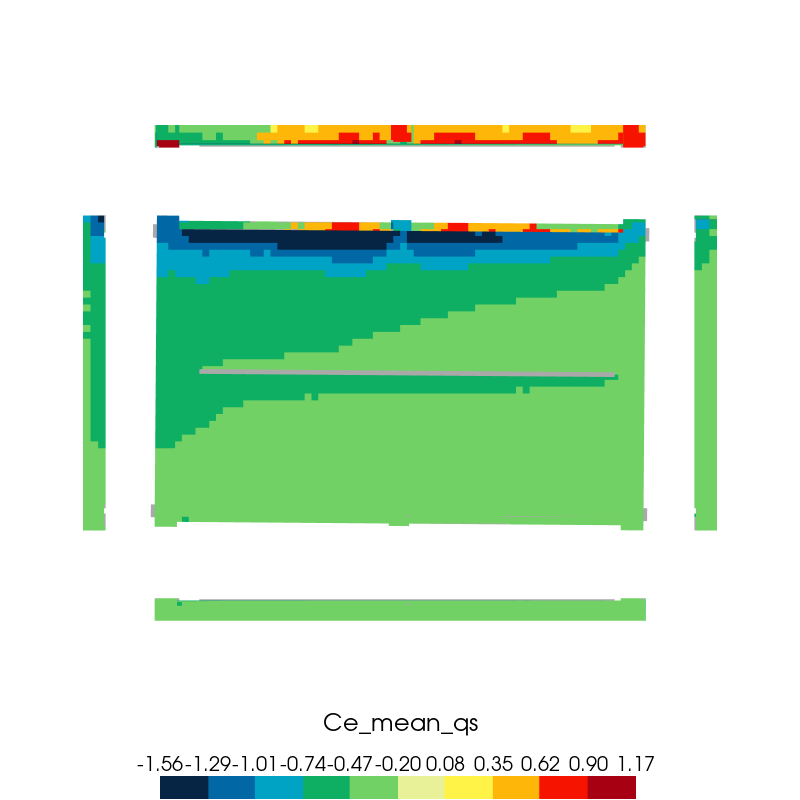

G100 013 Ce_5x5.vtp Ce_mean_qs


/home/ubuntu/.cache/pypoetry/virtualenvs/cfdmod-7yEqALRC-py3.10/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


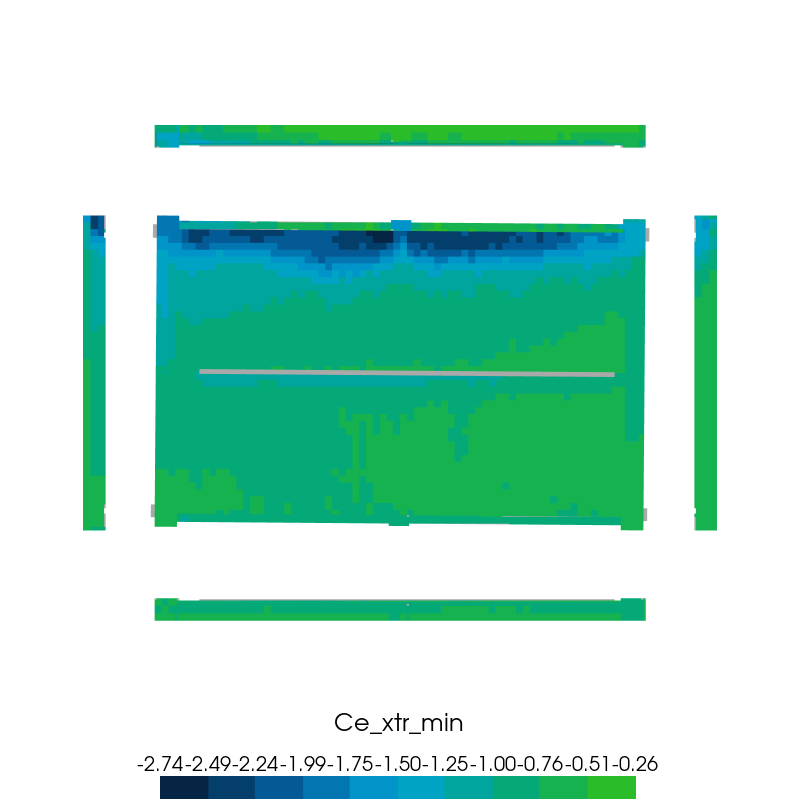

G100 013 Ce_5x5.vtp Ce_xtr_min


/home/ubuntu/.cache/pypoetry/virtualenvs/cfdmod-7yEqALRC-py3.10/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


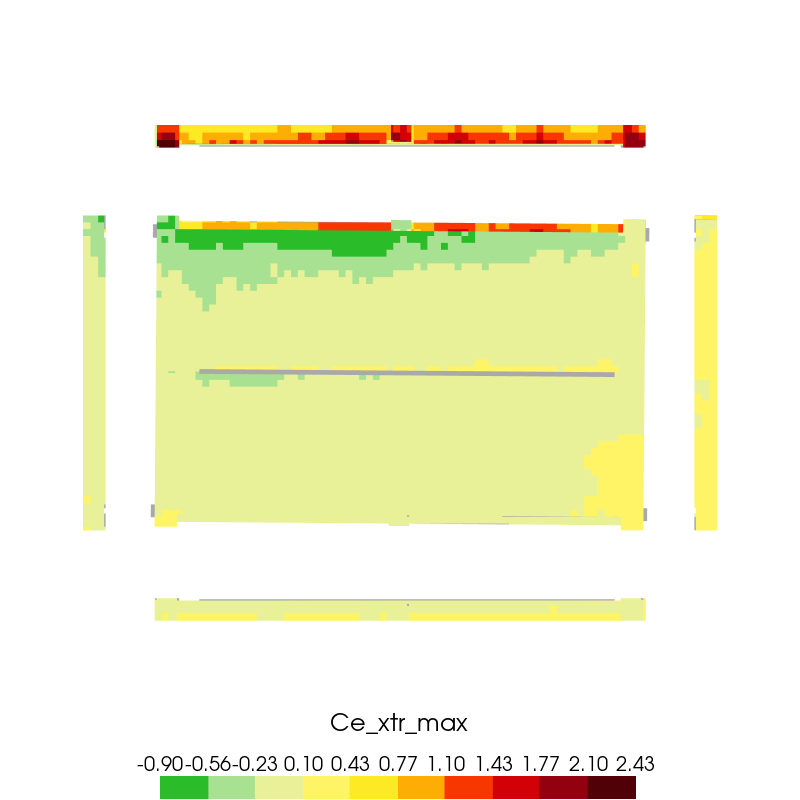

G100 013 Ce_5x5.vtp Ce_xtr_max


/home/ubuntu/.cache/pypoetry/virtualenvs/cfdmod-7yEqALRC-py3.10/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


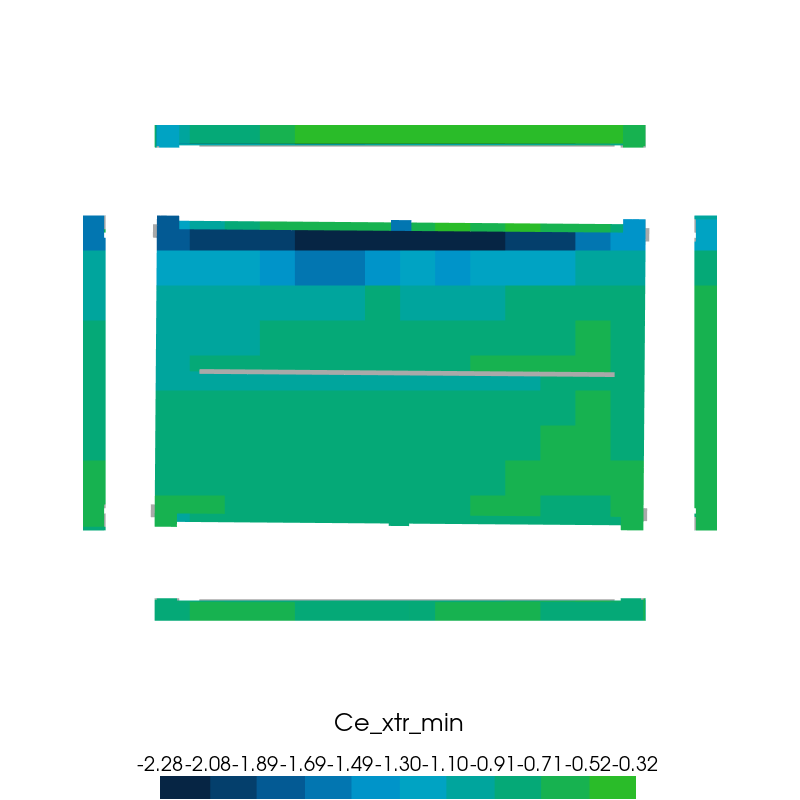

G100 013 Ce_25x25.vtp Ce_xtr_min


/home/ubuntu/.cache/pypoetry/virtualenvs/cfdmod-7yEqALRC-py3.10/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


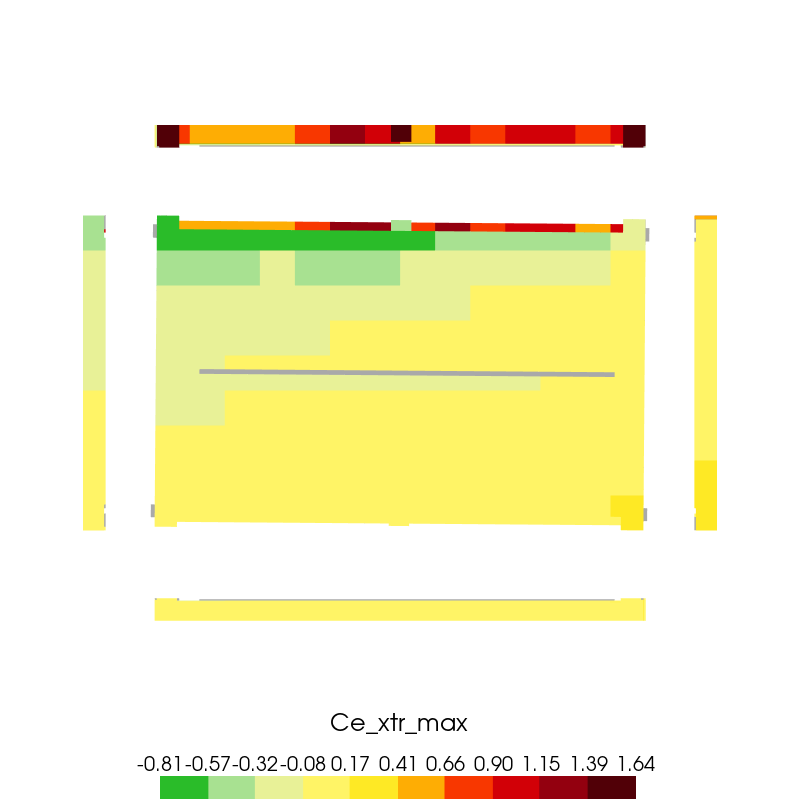

G100 013 Ce_25x25.vtp Ce_xtr_max


/home/ubuntu/.cache/pypoetry/virtualenvs/cfdmod-7yEqALRC-py3.10/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


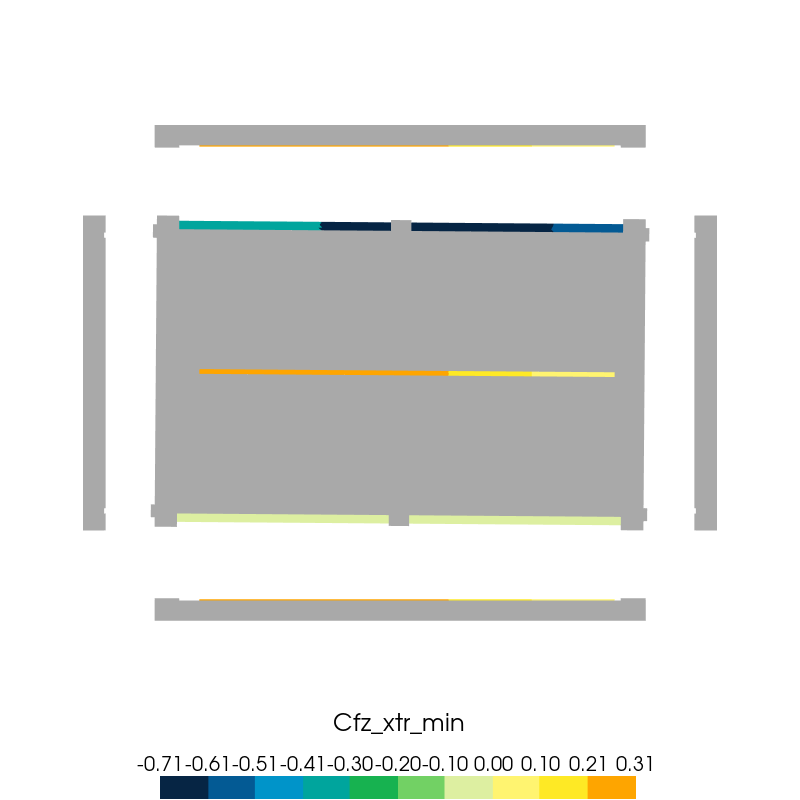

G100 013 Cf.vtp Cfz_xtr_min


/home/ubuntu/.cache/pypoetry/virtualenvs/cfdmod-7yEqALRC-py3.10/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


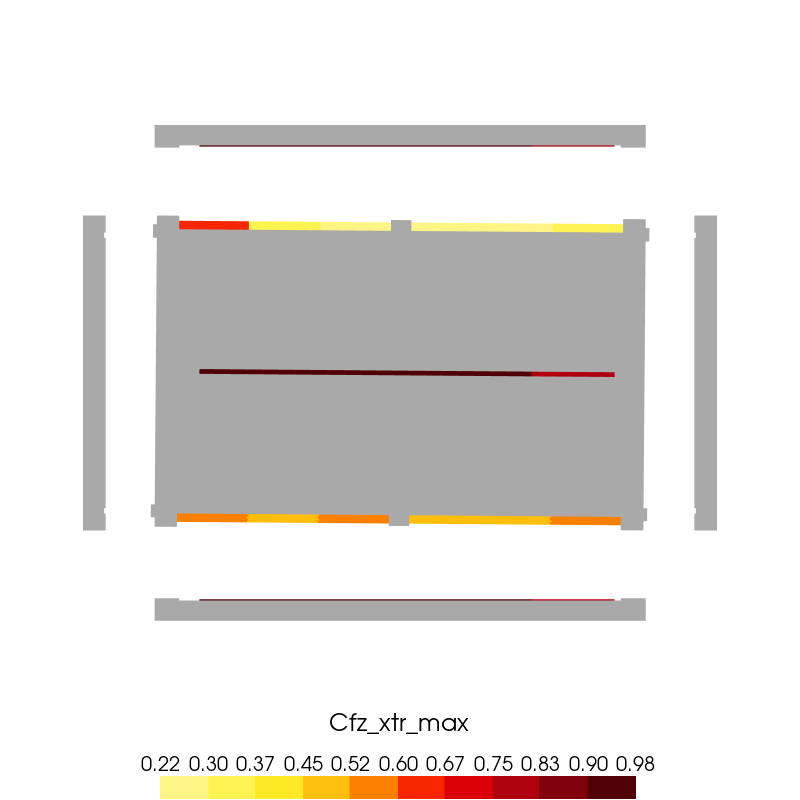

G100 013 Cf.vtp Cfz_xtr_max


/home/ubuntu/.cache/pypoetry/virtualenvs/cfdmod-7yEqALRC-py3.10/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


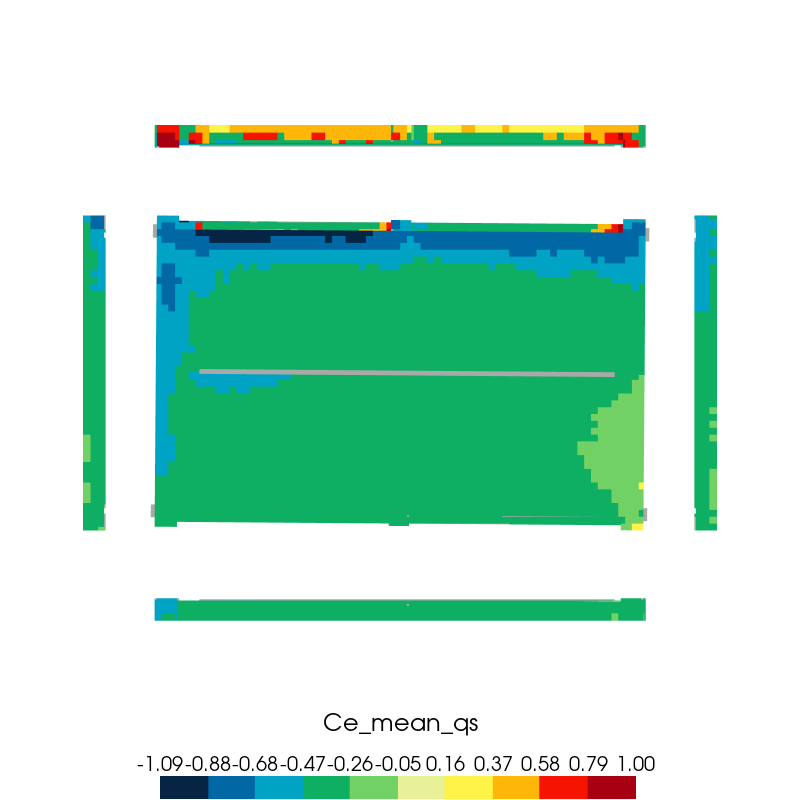

G100 058 Ce_5x5.vtp Ce_mean_qs


/home/ubuntu/.cache/pypoetry/virtualenvs/cfdmod-7yEqALRC-py3.10/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


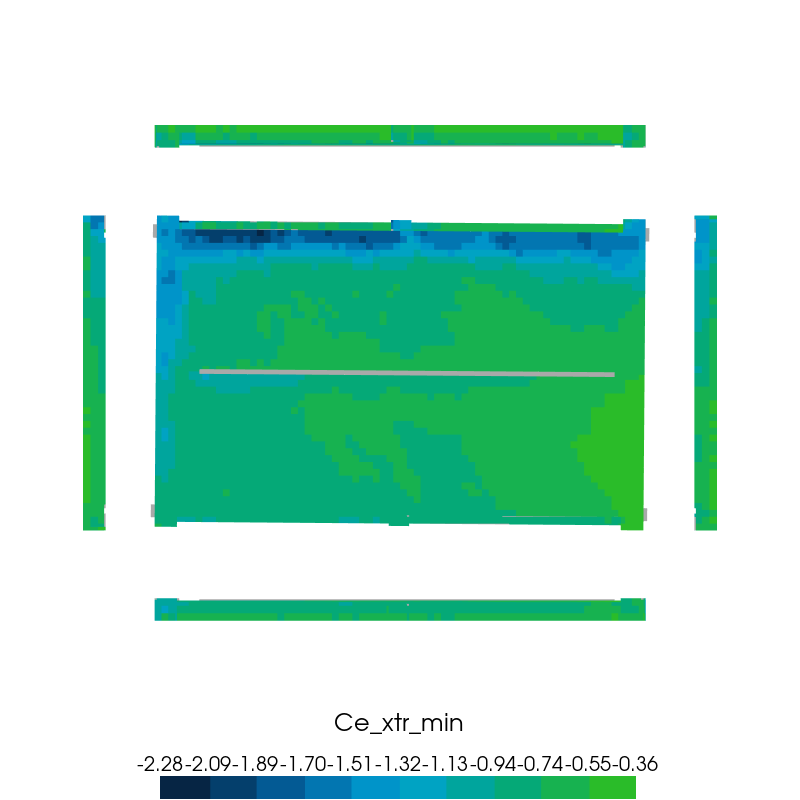

G100 058 Ce_5x5.vtp Ce_xtr_min


/home/ubuntu/.cache/pypoetry/virtualenvs/cfdmod-7yEqALRC-py3.10/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


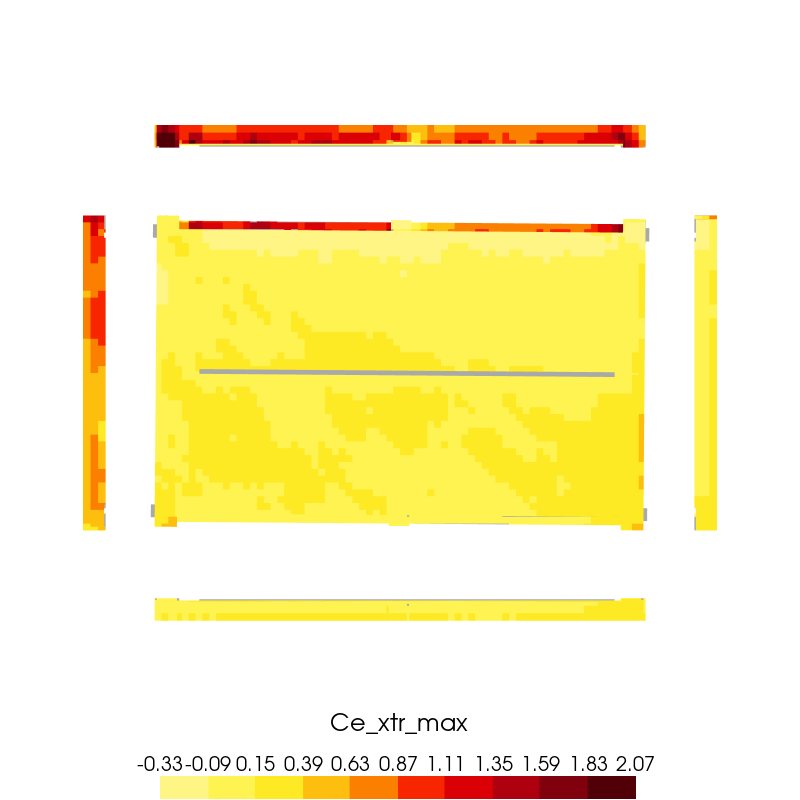

G100 058 Ce_5x5.vtp Ce_xtr_max


/home/ubuntu/.cache/pypoetry/virtualenvs/cfdmod-7yEqALRC-py3.10/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


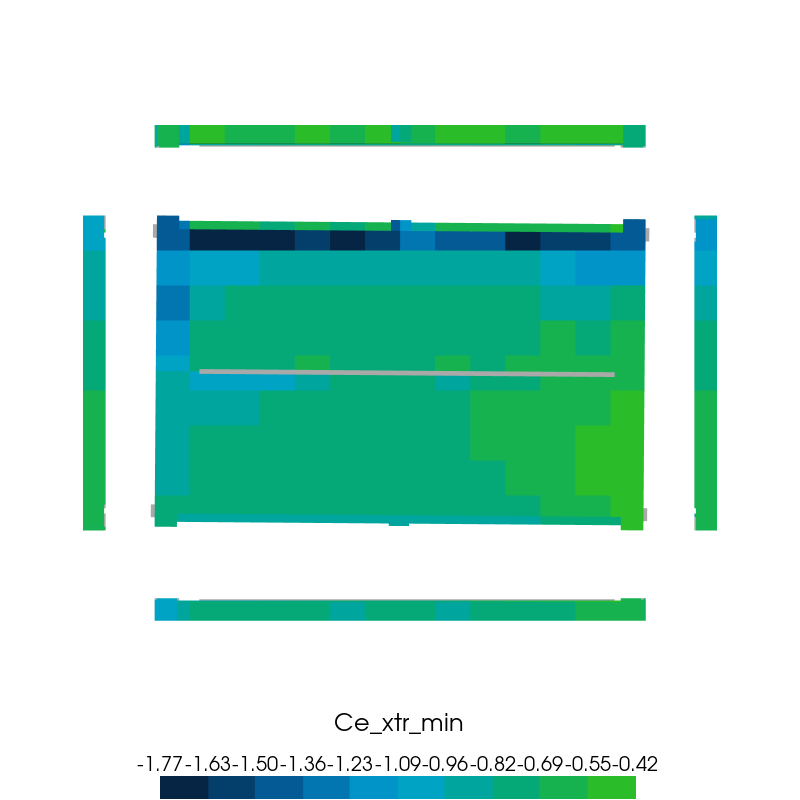

G100 058 Ce_25x25.vtp Ce_xtr_min


/home/ubuntu/.cache/pypoetry/virtualenvs/cfdmod-7yEqALRC-py3.10/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


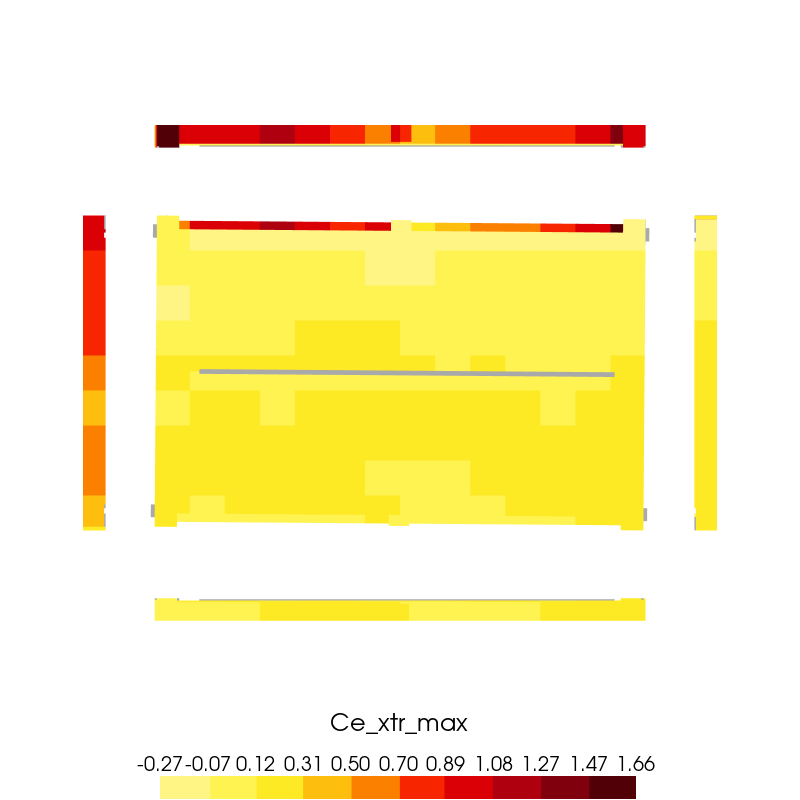

G100 058 Ce_25x25.vtp Ce_xtr_max


/home/ubuntu/.cache/pypoetry/virtualenvs/cfdmod-7yEqALRC-py3.10/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


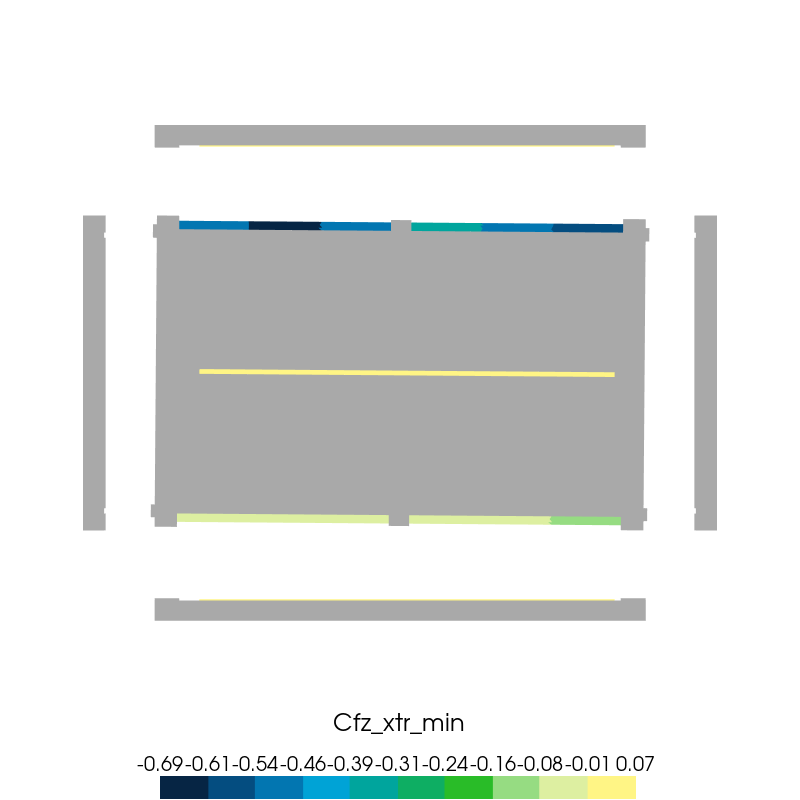

/home/ubuntu/.cache/pypoetry/virtualenvs/cfdmod-7yEqALRC-py3.10/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


G100 058 Cf.vtp Cfz_xtr_min


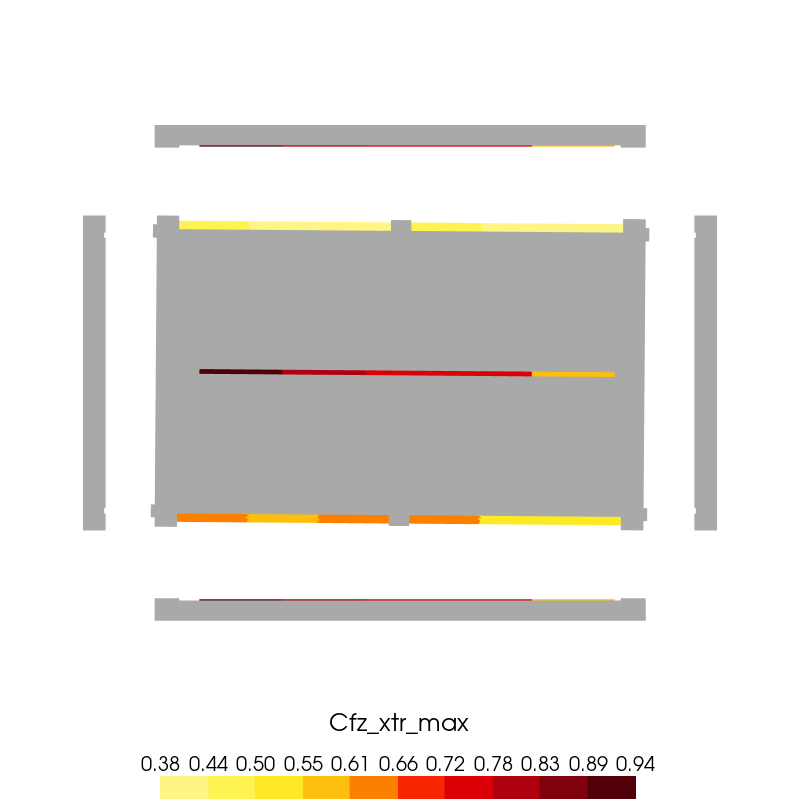

G100 058 Cf.vtp Cfz_xtr_max


/home/ubuntu/.cache/pypoetry/virtualenvs/cfdmod-7yEqALRC-py3.10/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


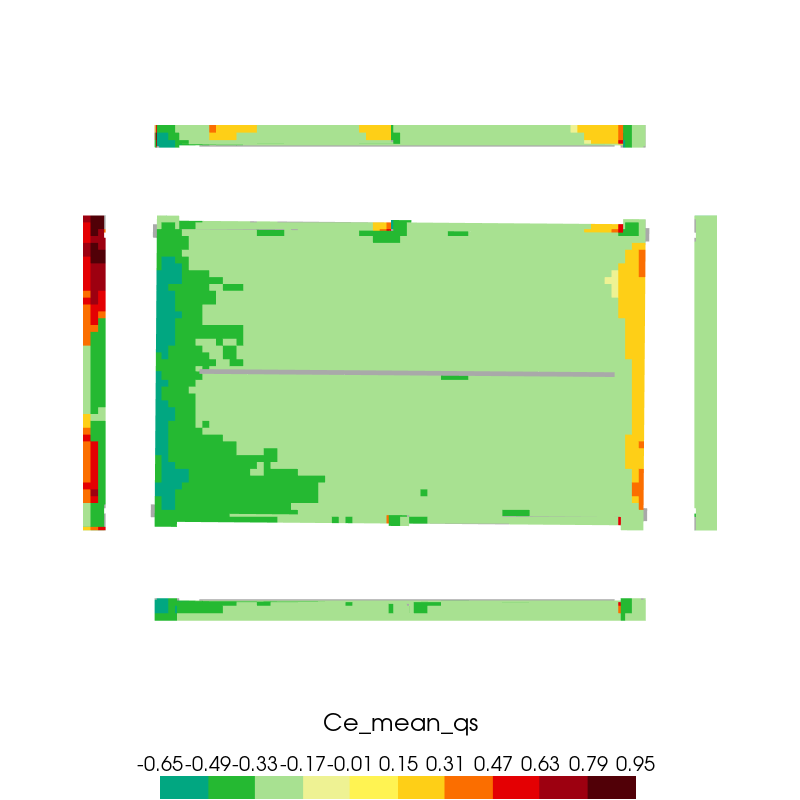

G100 103 Ce_5x5.vtp Ce_mean_qs


/home/ubuntu/.cache/pypoetry/virtualenvs/cfdmod-7yEqALRC-py3.10/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


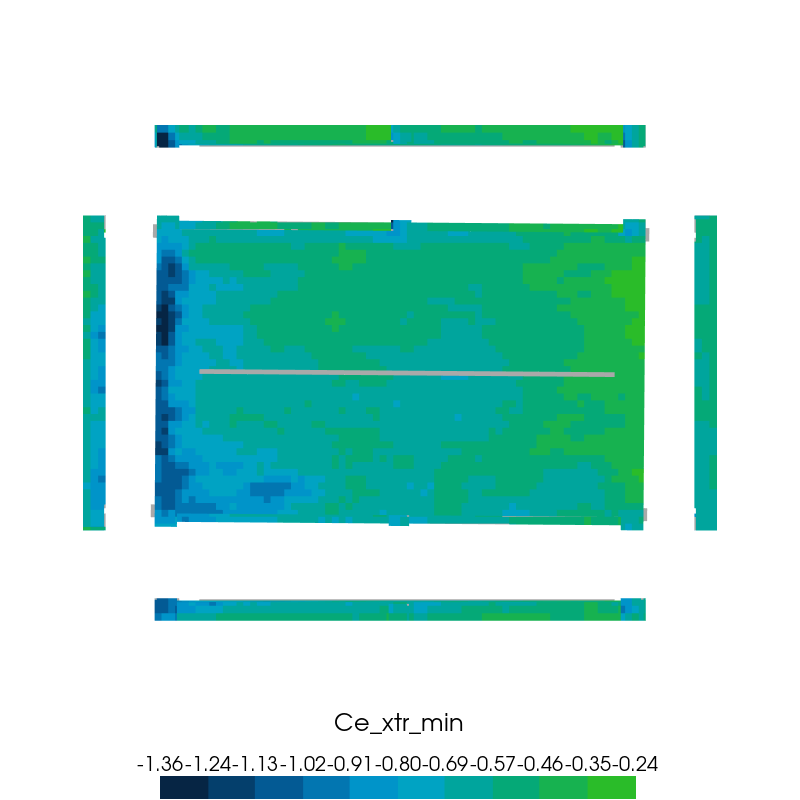

G100 103 Ce_5x5.vtp Ce_xtr_min


/home/ubuntu/.cache/pypoetry/virtualenvs/cfdmod-7yEqALRC-py3.10/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


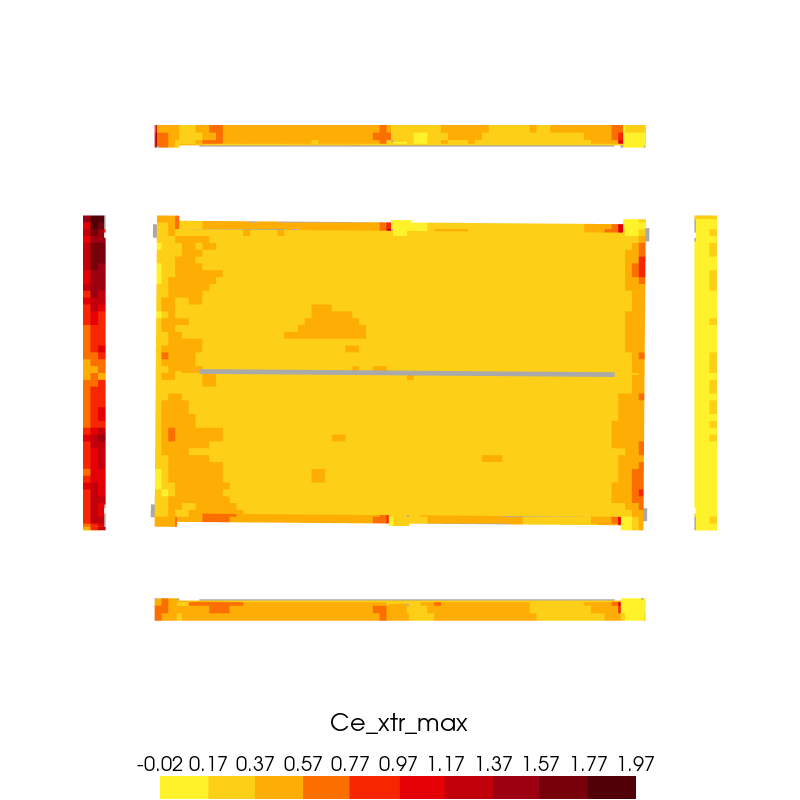

G100 103 Ce_5x5.vtp Ce_xtr_max


/home/ubuntu/.cache/pypoetry/virtualenvs/cfdmod-7yEqALRC-py3.10/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


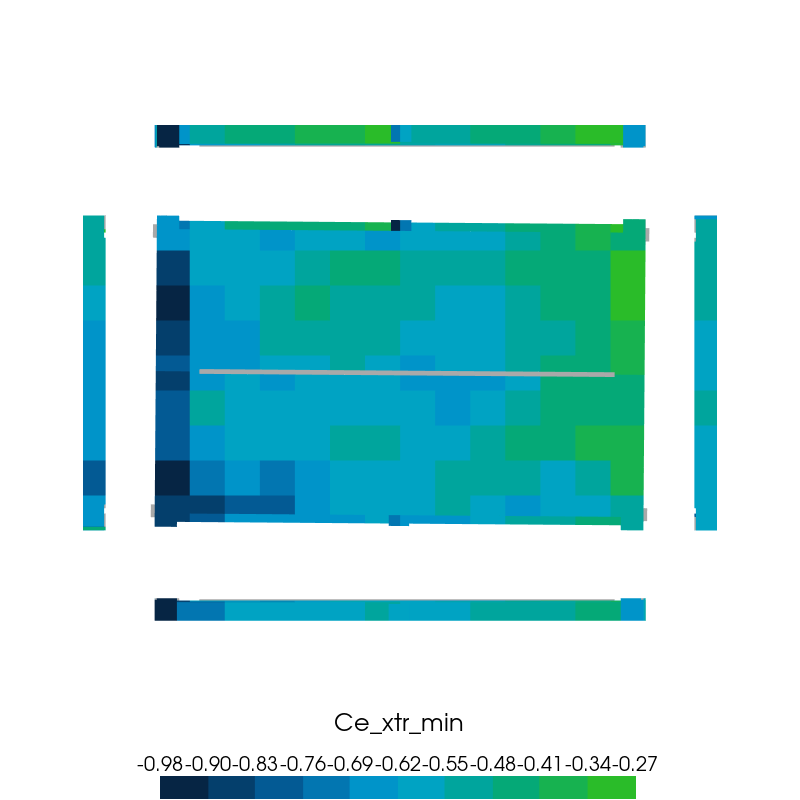

G100 103 Ce_25x25.vtp Ce_xtr_min


/home/ubuntu/.cache/pypoetry/virtualenvs/cfdmod-7yEqALRC-py3.10/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


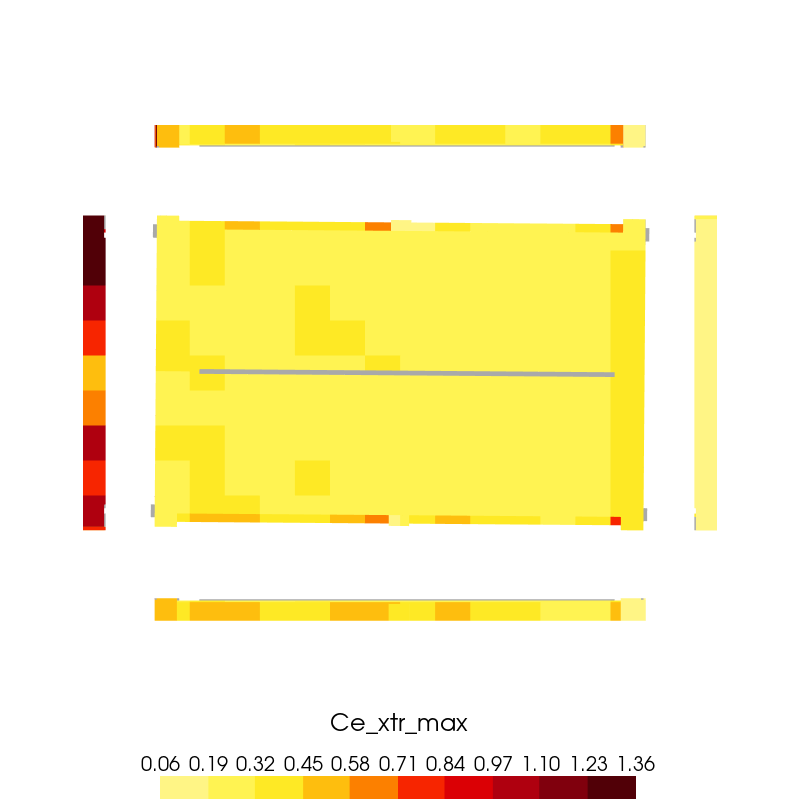

G100 103 Ce_25x25.vtp Ce_xtr_max


/home/ubuntu/.cache/pypoetry/virtualenvs/cfdmod-7yEqALRC-py3.10/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


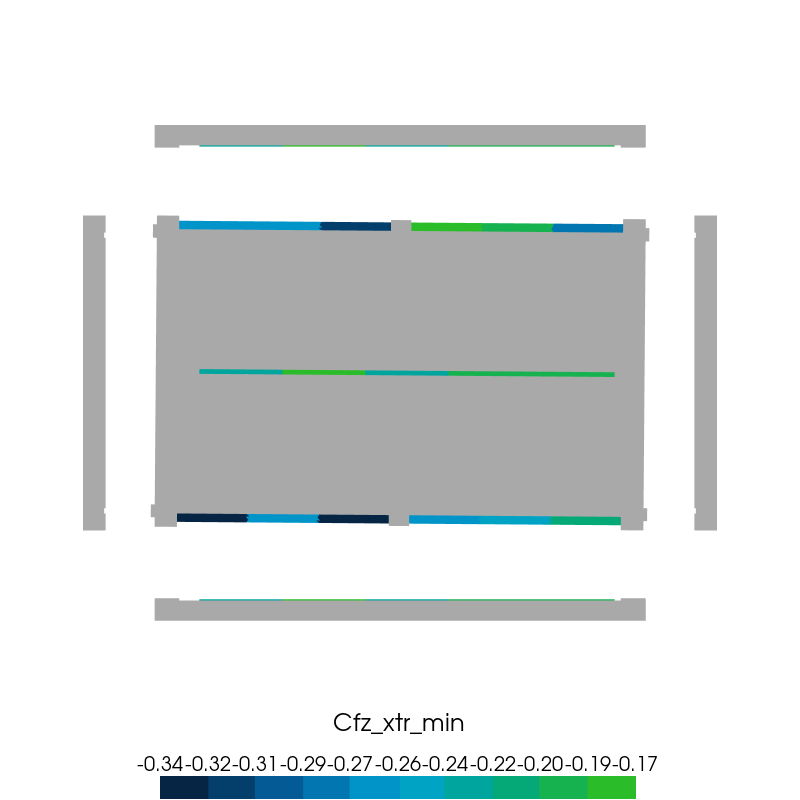

G100 103 Cf.vtp Cfz_xtr_min


/home/ubuntu/.cache/pypoetry/virtualenvs/cfdmod-7yEqALRC-py3.10/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


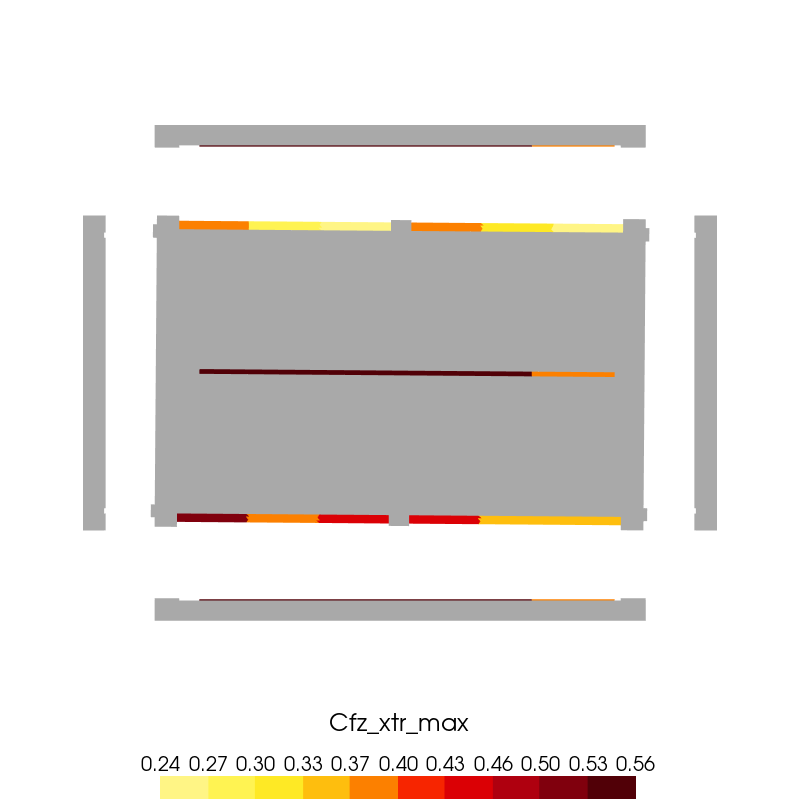

G100 103 Cf.vtp Cfz_xtr_max


/home/ubuntu/.cache/pypoetry/virtualenvs/cfdmod-7yEqALRC-py3.10/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


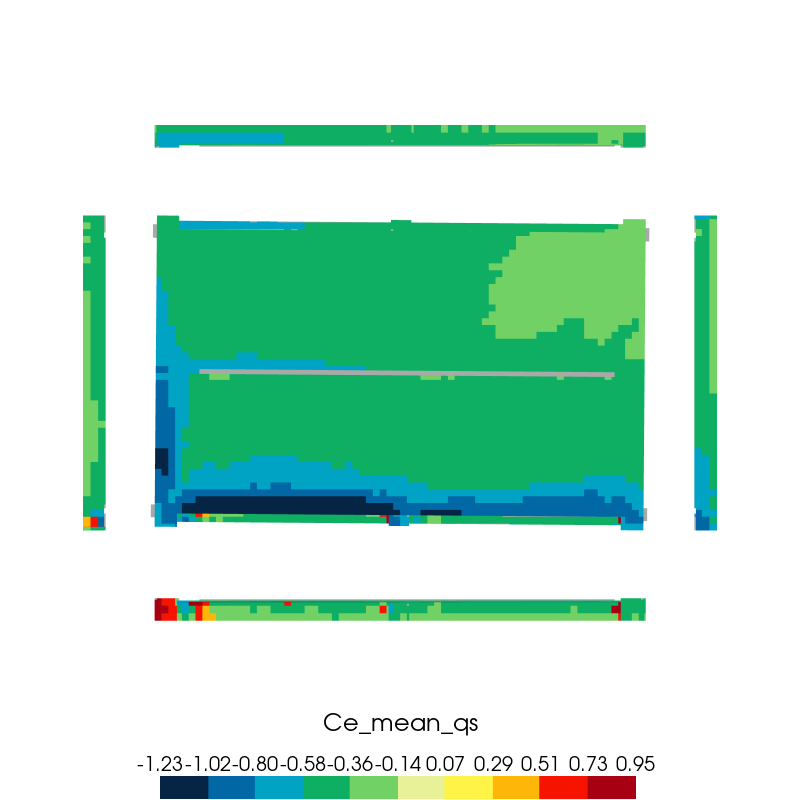

G100 148 Ce_5x5.vtp Ce_mean_qs


/home/ubuntu/.cache/pypoetry/virtualenvs/cfdmod-7yEqALRC-py3.10/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


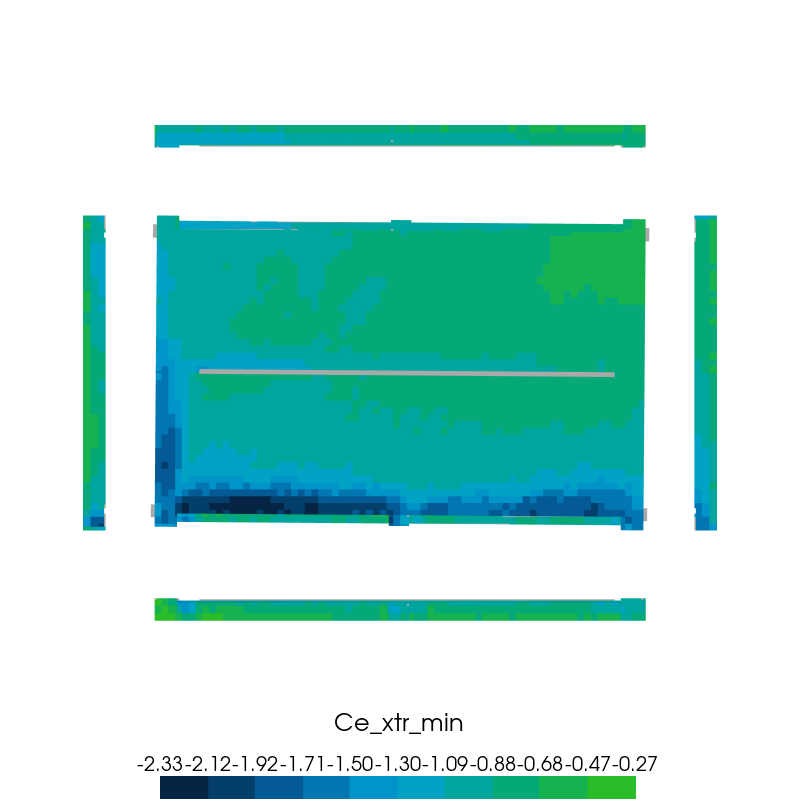

G100 148 Ce_5x5.vtp Ce_xtr_min


/home/ubuntu/.cache/pypoetry/virtualenvs/cfdmod-7yEqALRC-py3.10/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


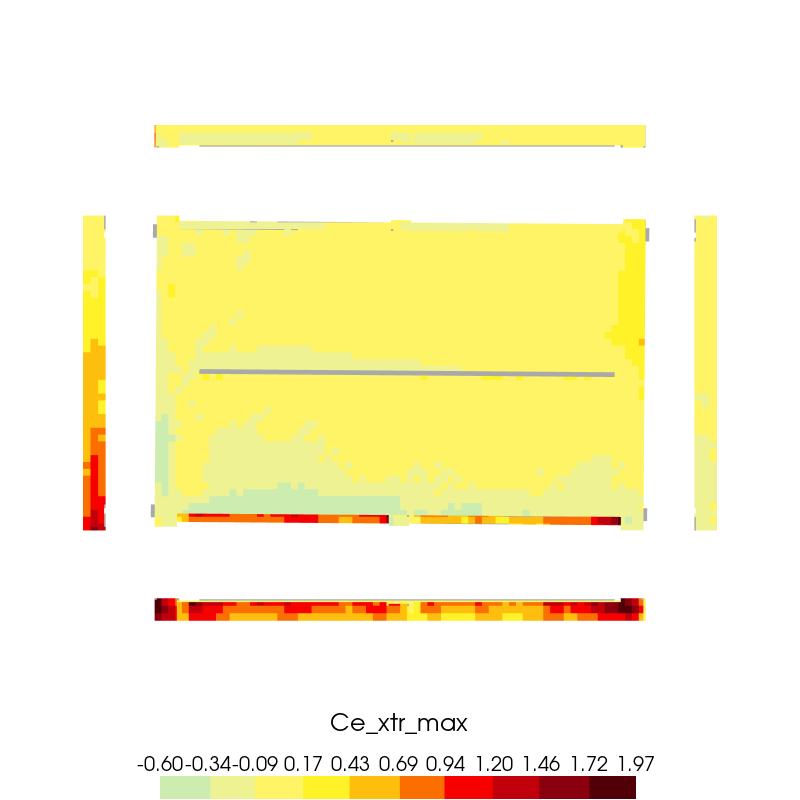

G100 148 Ce_5x5.vtp Ce_xtr_max


/home/ubuntu/.cache/pypoetry/virtualenvs/cfdmod-7yEqALRC-py3.10/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


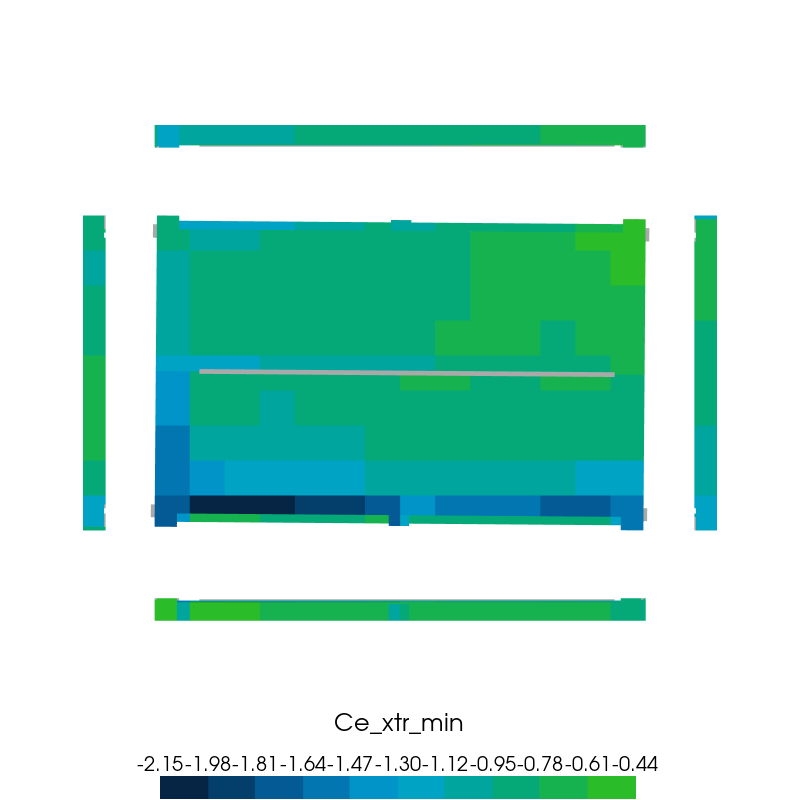

G100 148 Ce_25x25.vtp Ce_xtr_min


/home/ubuntu/.cache/pypoetry/virtualenvs/cfdmod-7yEqALRC-py3.10/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


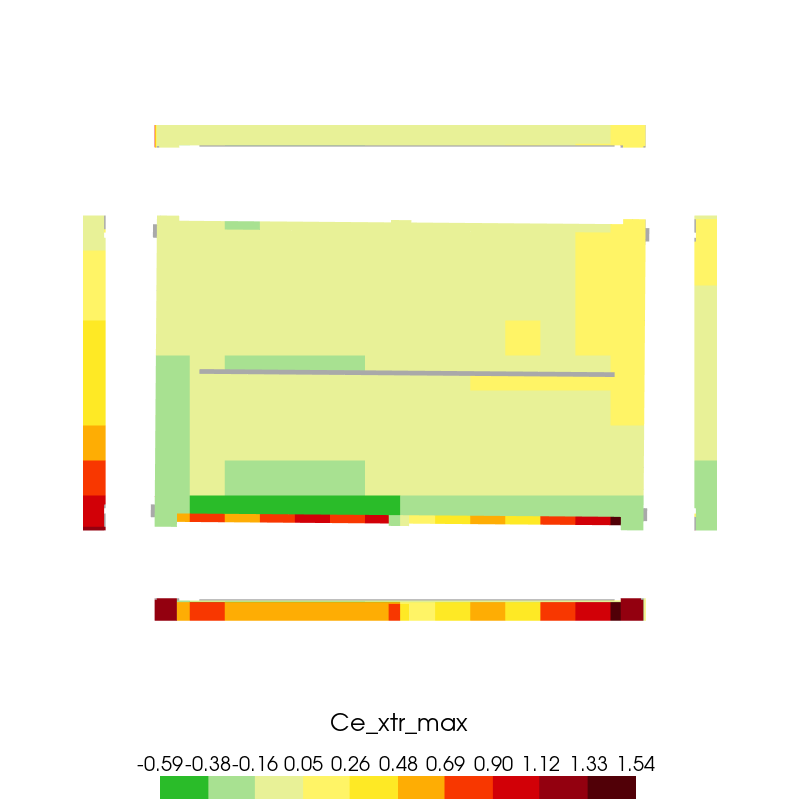

G100 148 Ce_25x25.vtp Ce_xtr_max


/home/ubuntu/.cache/pypoetry/virtualenvs/cfdmod-7yEqALRC-py3.10/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


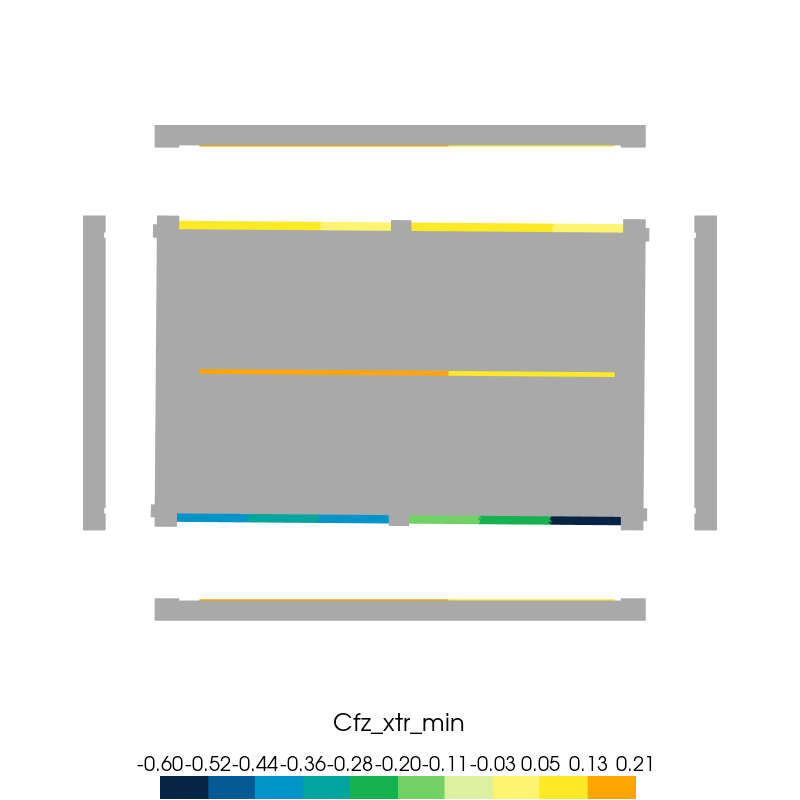

G100 148 Cf.vtp Cfz_xtr_min


/home/ubuntu/.cache/pypoetry/virtualenvs/cfdmod-7yEqALRC-py3.10/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


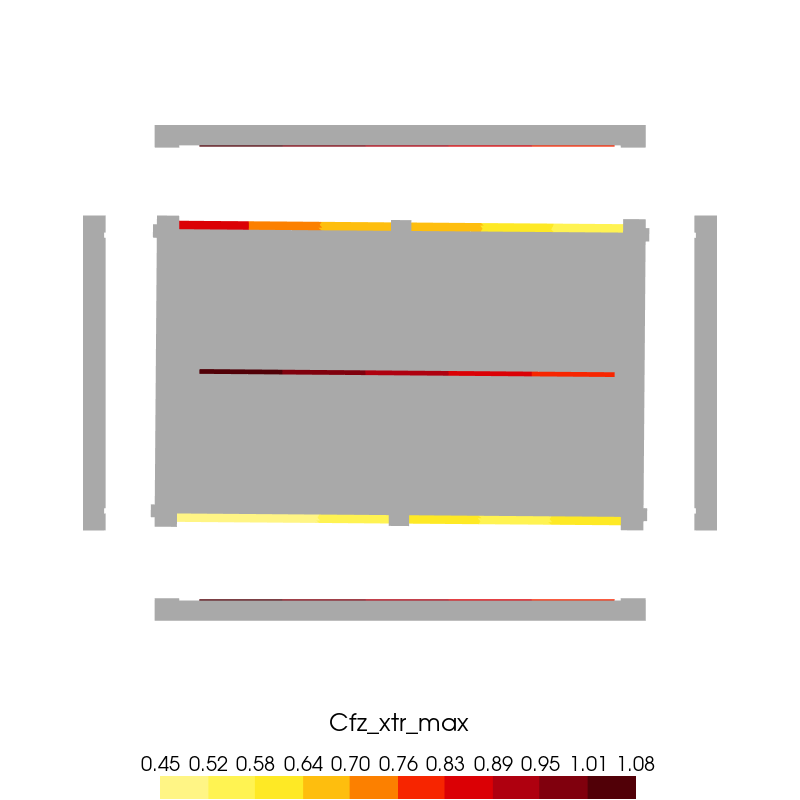

G100 148 Cf.vtp Cfz_xtr_max


/home/ubuntu/.cache/pypoetry/virtualenvs/cfdmod-7yEqALRC-py3.10/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


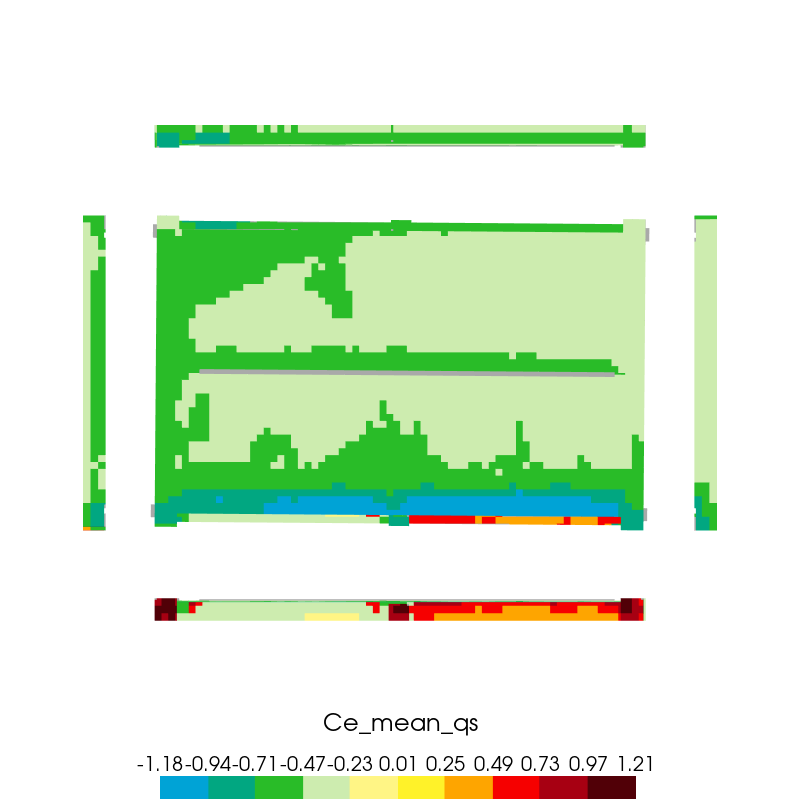

G100 193 Ce_5x5.vtp Ce_mean_qs


/home/ubuntu/.cache/pypoetry/virtualenvs/cfdmod-7yEqALRC-py3.10/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


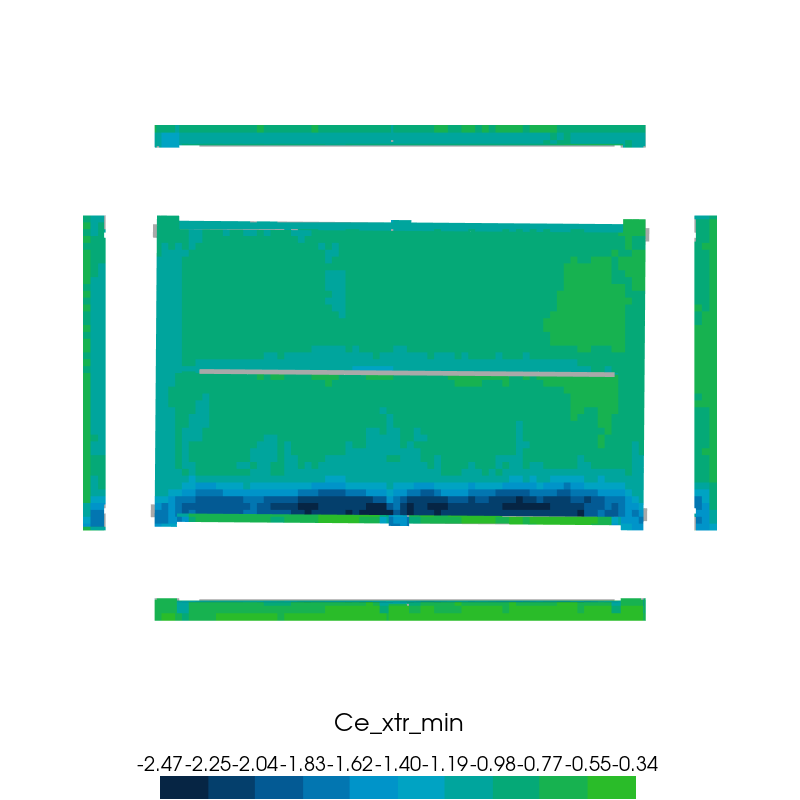

G100 193 Ce_5x5.vtp Ce_xtr_min


/home/ubuntu/.cache/pypoetry/virtualenvs/cfdmod-7yEqALRC-py3.10/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


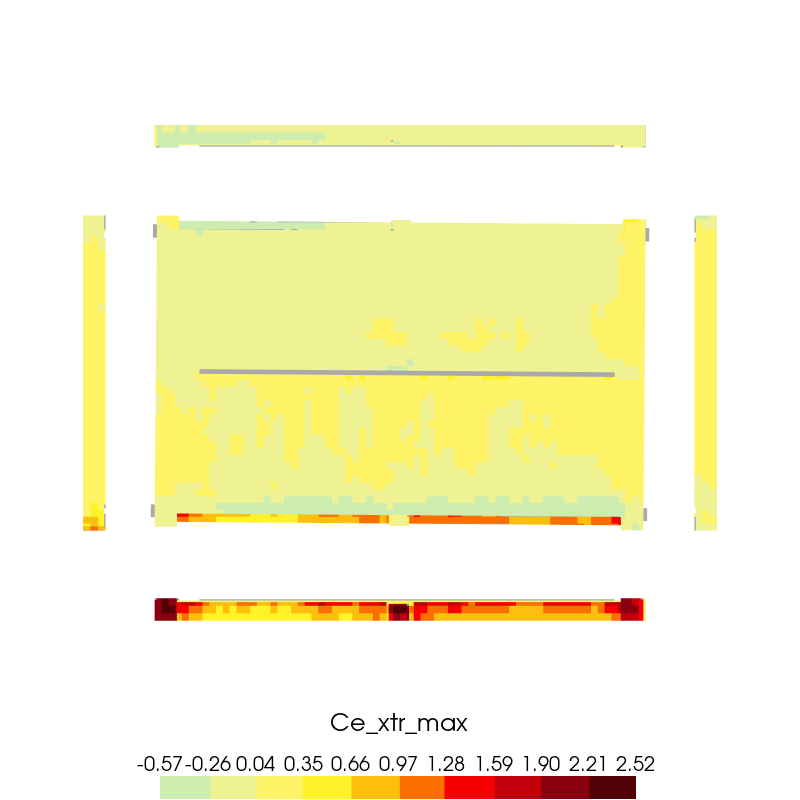

G100 193 Ce_5x5.vtp Ce_xtr_max


/home/ubuntu/.cache/pypoetry/virtualenvs/cfdmod-7yEqALRC-py3.10/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


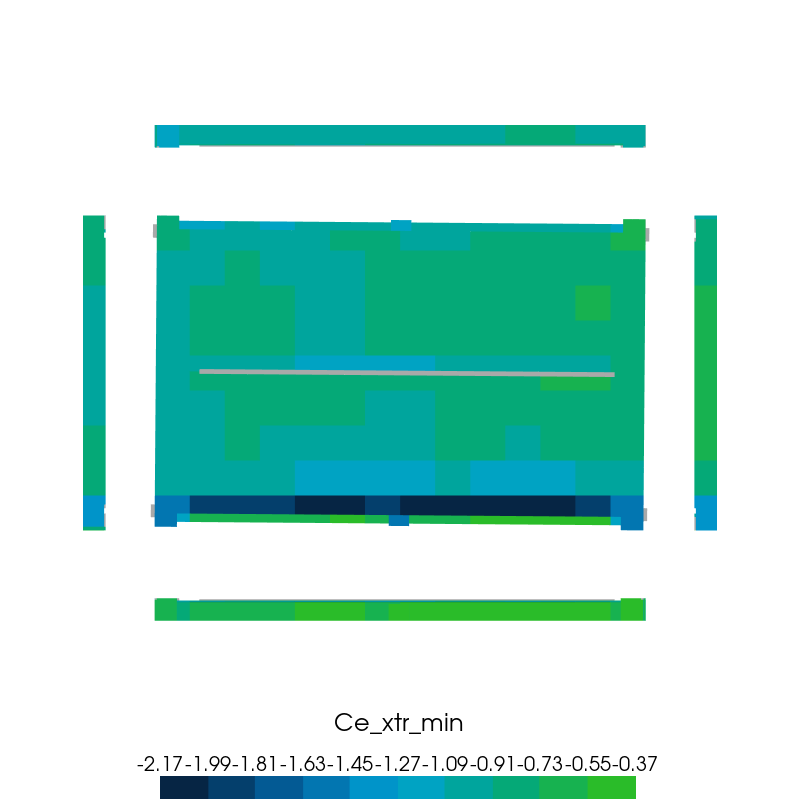

G100 193 Ce_25x25.vtp Ce_xtr_min


/home/ubuntu/.cache/pypoetry/virtualenvs/cfdmod-7yEqALRC-py3.10/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


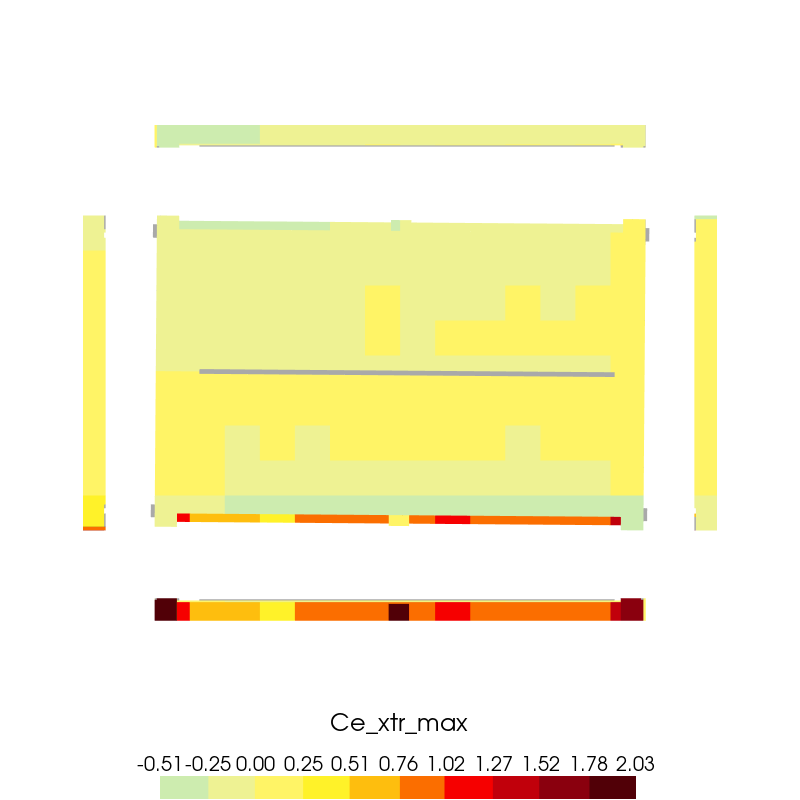

G100 193 Ce_25x25.vtp Ce_xtr_max


/home/ubuntu/.cache/pypoetry/virtualenvs/cfdmod-7yEqALRC-py3.10/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


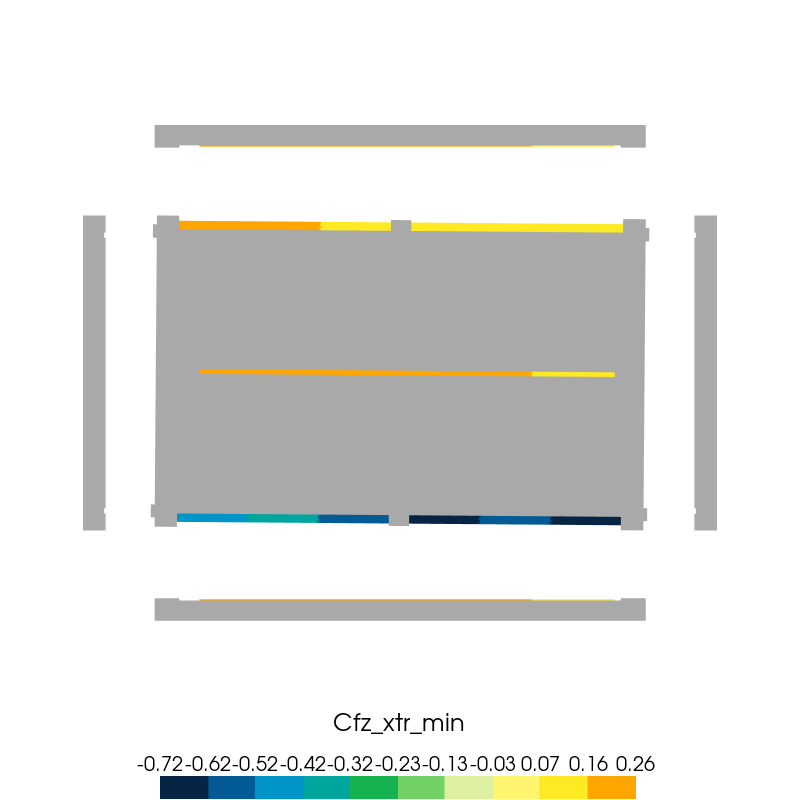

G100 193 Cf.vtp Cfz_xtr_min


/home/ubuntu/.cache/pypoetry/virtualenvs/cfdmod-7yEqALRC-py3.10/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


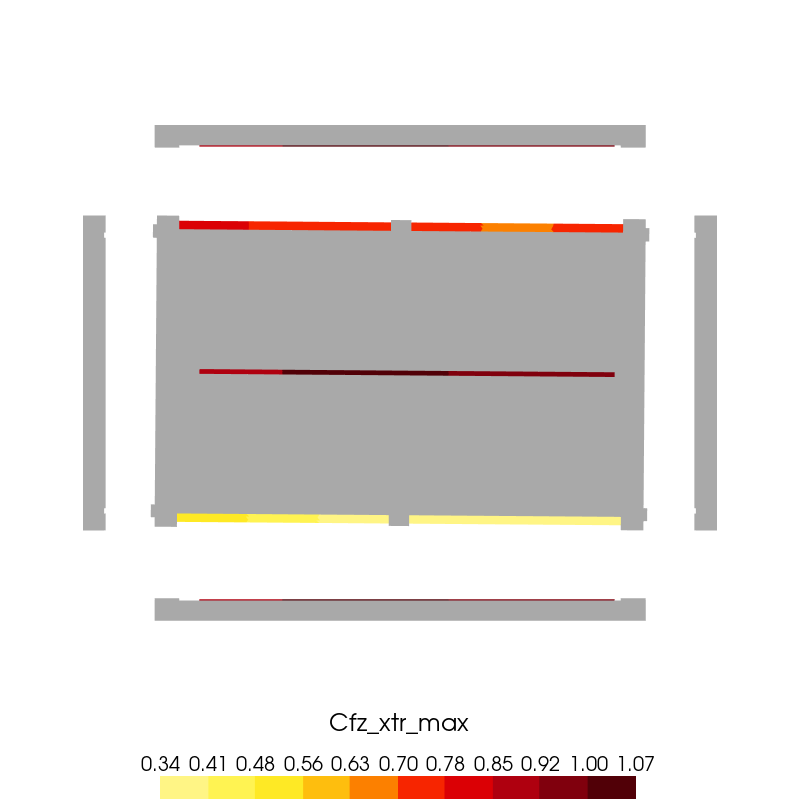

G100 193 Cf.vtp Cfz_xtr_max


/home/ubuntu/.cache/pypoetry/virtualenvs/cfdmod-7yEqALRC-py3.10/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


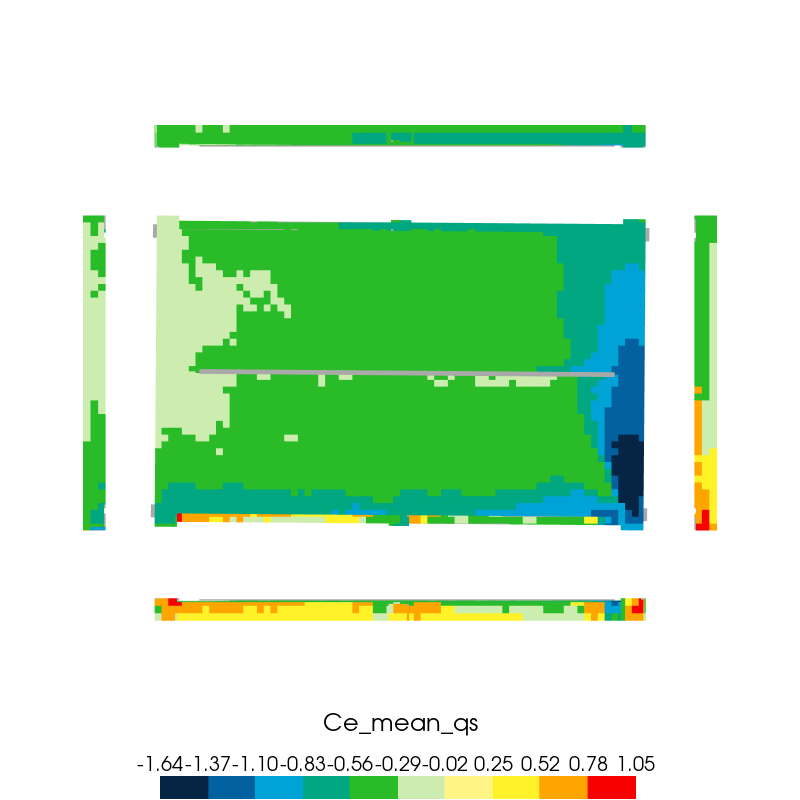

G100 238 Ce_5x5.vtp Ce_mean_qs


/home/ubuntu/.cache/pypoetry/virtualenvs/cfdmod-7yEqALRC-py3.10/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


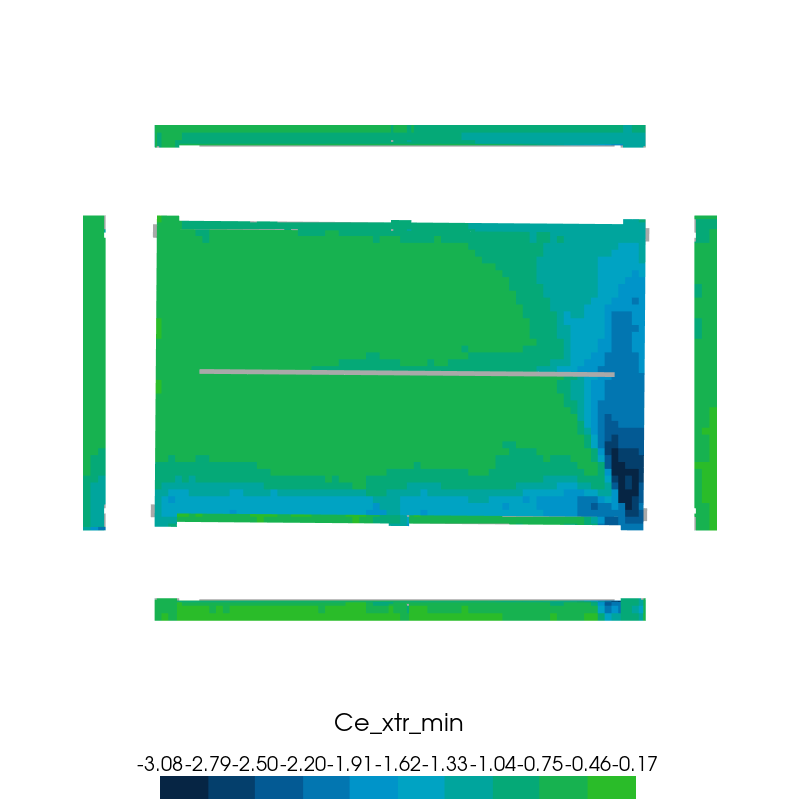

G100 238 Ce_5x5.vtp Ce_xtr_min


/home/ubuntu/.cache/pypoetry/virtualenvs/cfdmod-7yEqALRC-py3.10/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


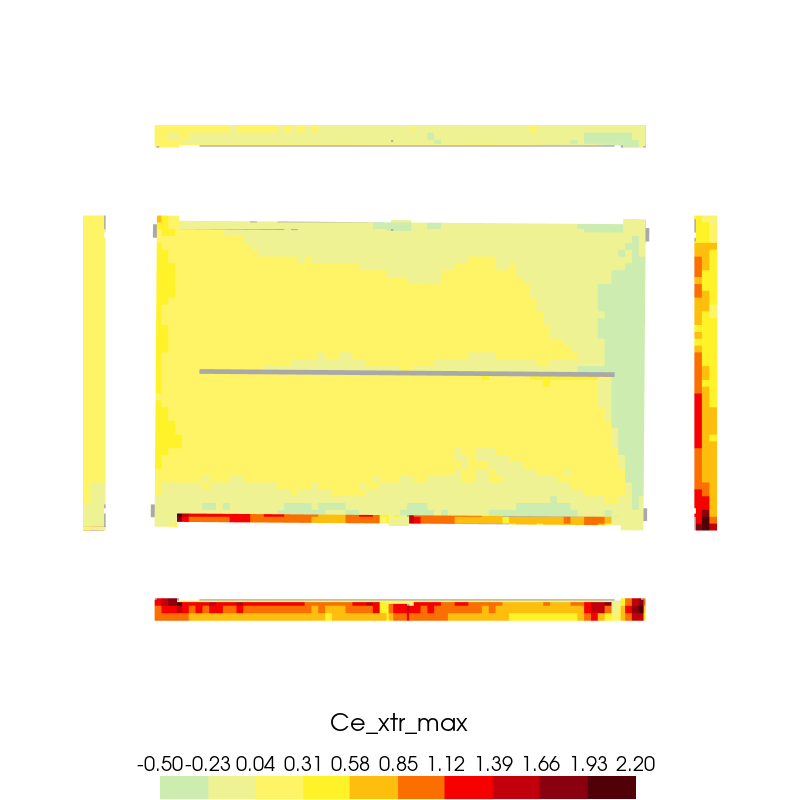

G100 238 Ce_5x5.vtp Ce_xtr_max


/home/ubuntu/.cache/pypoetry/virtualenvs/cfdmod-7yEqALRC-py3.10/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


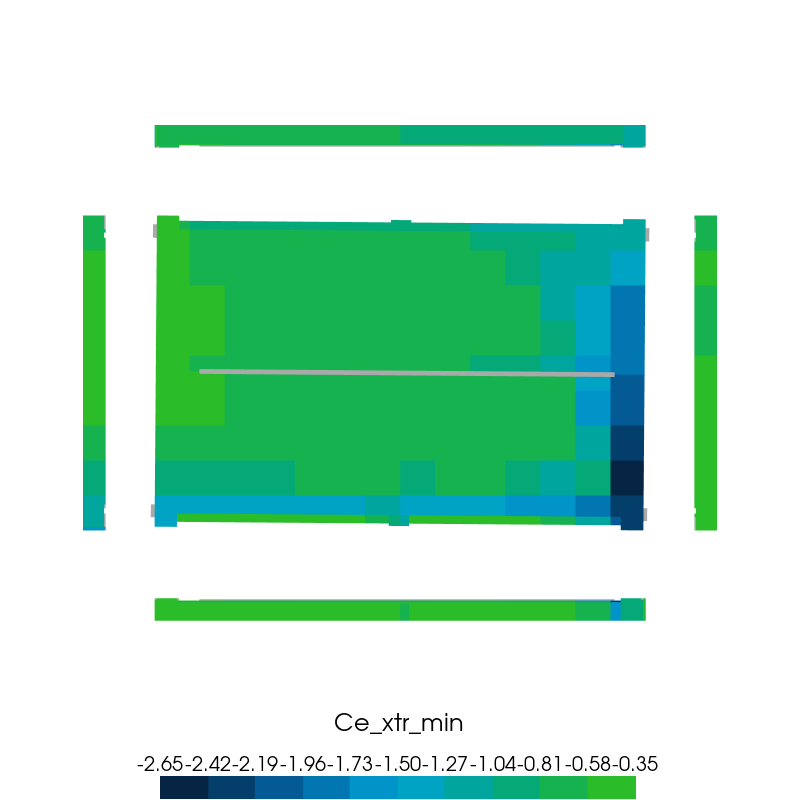

G100 238 Ce_25x25.vtp Ce_xtr_min


/home/ubuntu/.cache/pypoetry/virtualenvs/cfdmod-7yEqALRC-py3.10/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


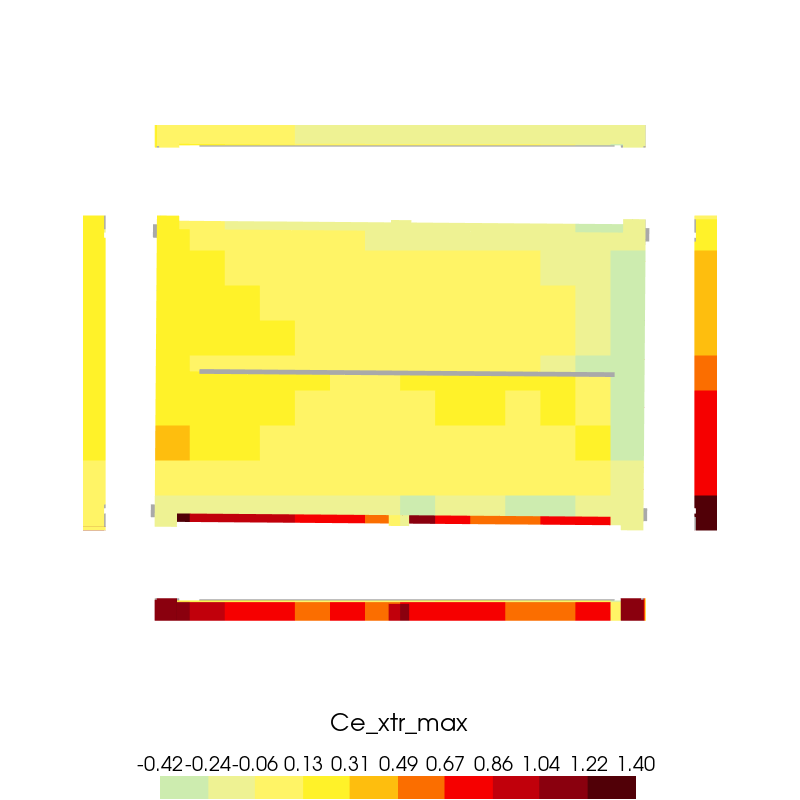

G100 238 Ce_25x25.vtp Ce_xtr_max


/home/ubuntu/.cache/pypoetry/virtualenvs/cfdmod-7yEqALRC-py3.10/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


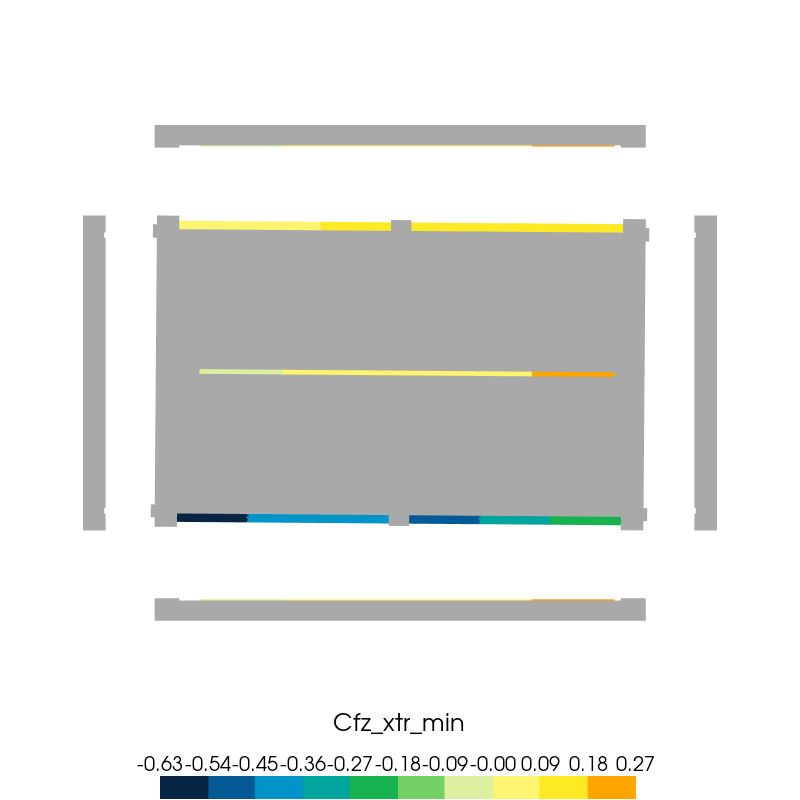

G100 238 Cf.vtp Cfz_xtr_min


/home/ubuntu/.cache/pypoetry/virtualenvs/cfdmod-7yEqALRC-py3.10/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


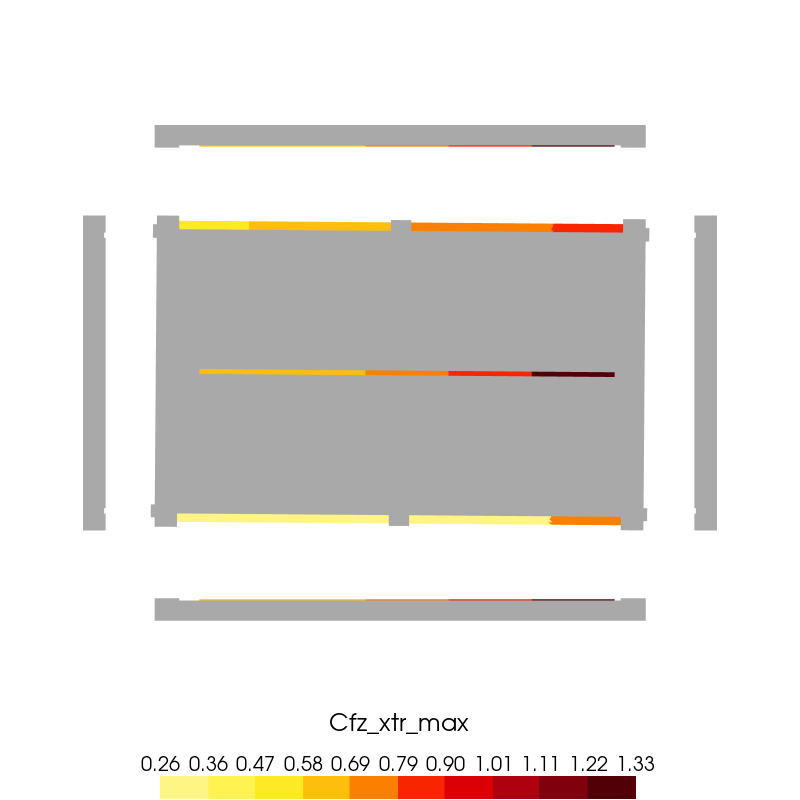

G100 238 Cf.vtp Cfz_xtr_max


/home/ubuntu/.cache/pypoetry/virtualenvs/cfdmod-7yEqALRC-py3.10/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


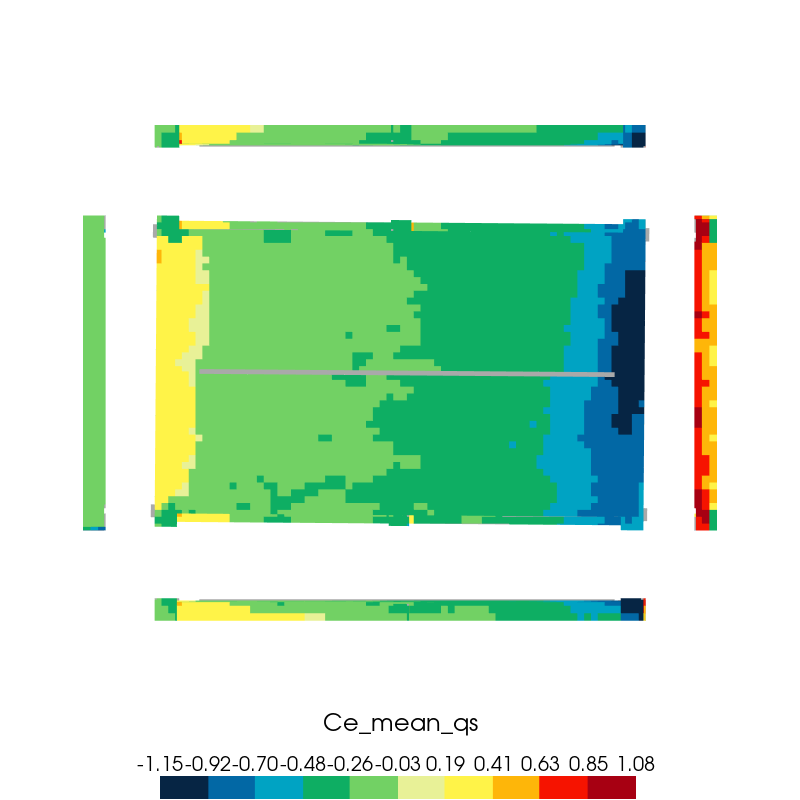

G100 283 Ce_5x5.vtp Ce_mean_qs


/home/ubuntu/.cache/pypoetry/virtualenvs/cfdmod-7yEqALRC-py3.10/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


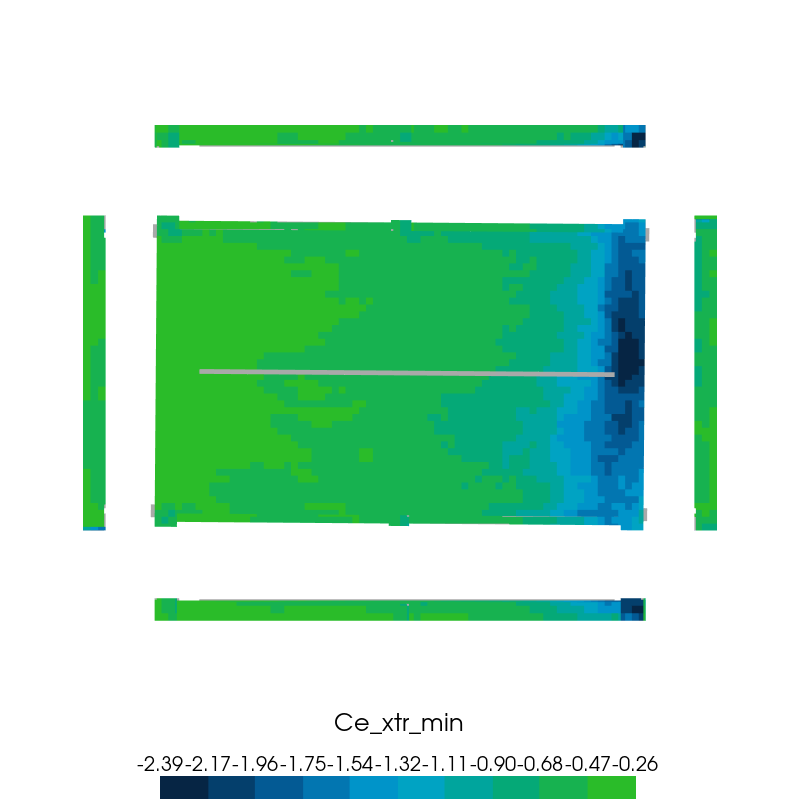

G100 283 Ce_5x5.vtp Ce_xtr_min


/home/ubuntu/.cache/pypoetry/virtualenvs/cfdmod-7yEqALRC-py3.10/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


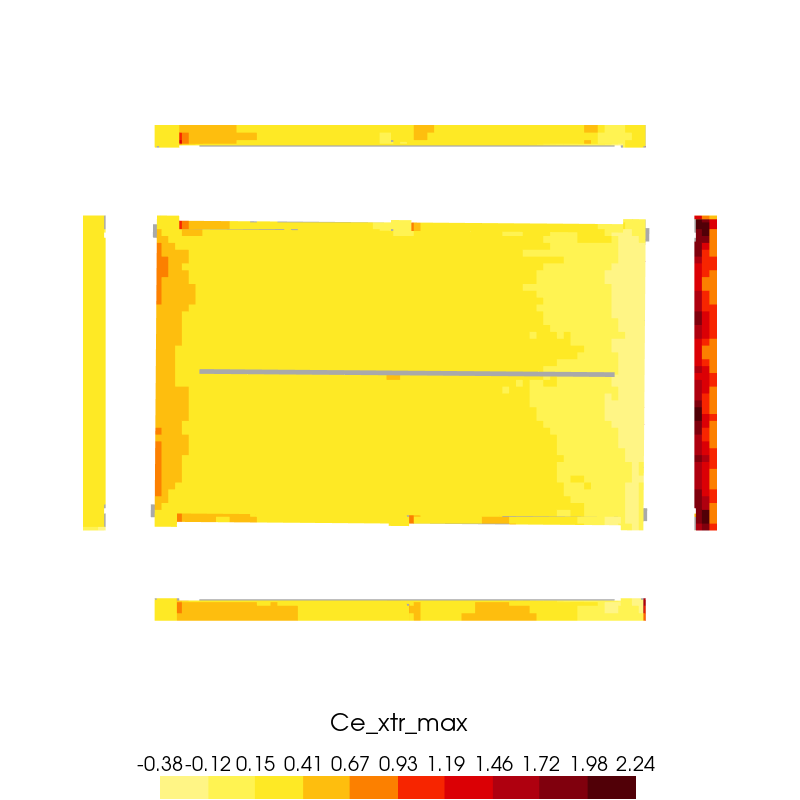

G100 283 Ce_5x5.vtp Ce_xtr_max


/home/ubuntu/.cache/pypoetry/virtualenvs/cfdmod-7yEqALRC-py3.10/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


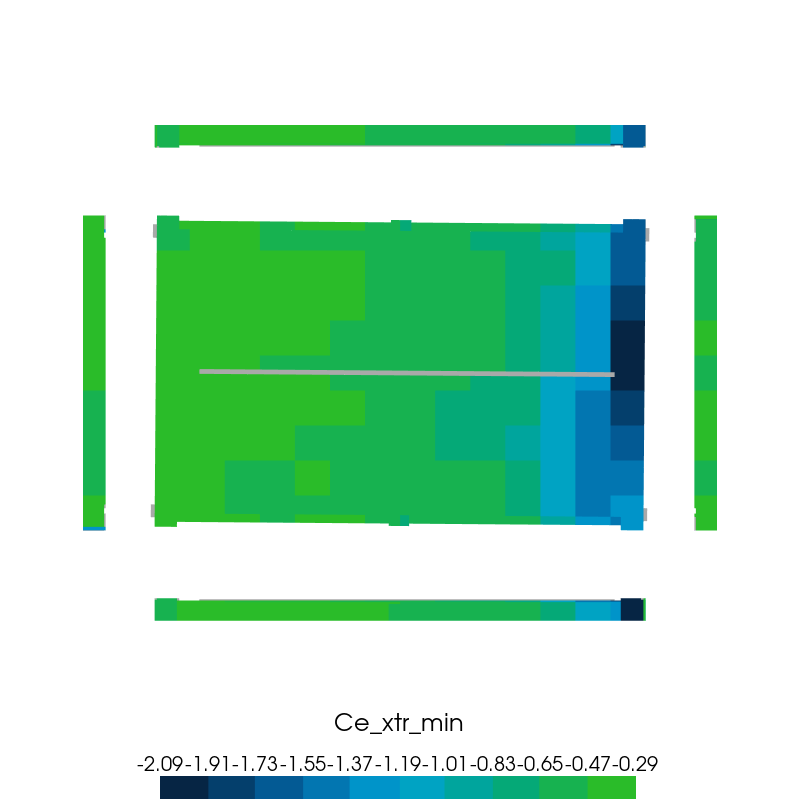

G100 283 Ce_25x25.vtp Ce_xtr_min


/home/ubuntu/.cache/pypoetry/virtualenvs/cfdmod-7yEqALRC-py3.10/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


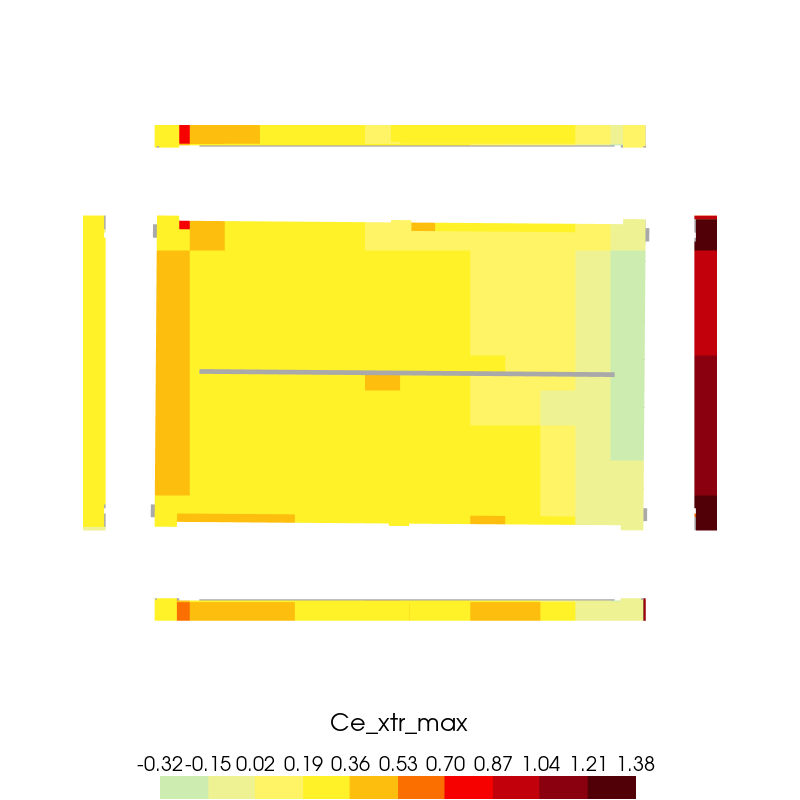

G100 283 Ce_25x25.vtp Ce_xtr_max


/home/ubuntu/.cache/pypoetry/virtualenvs/cfdmod-7yEqALRC-py3.10/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


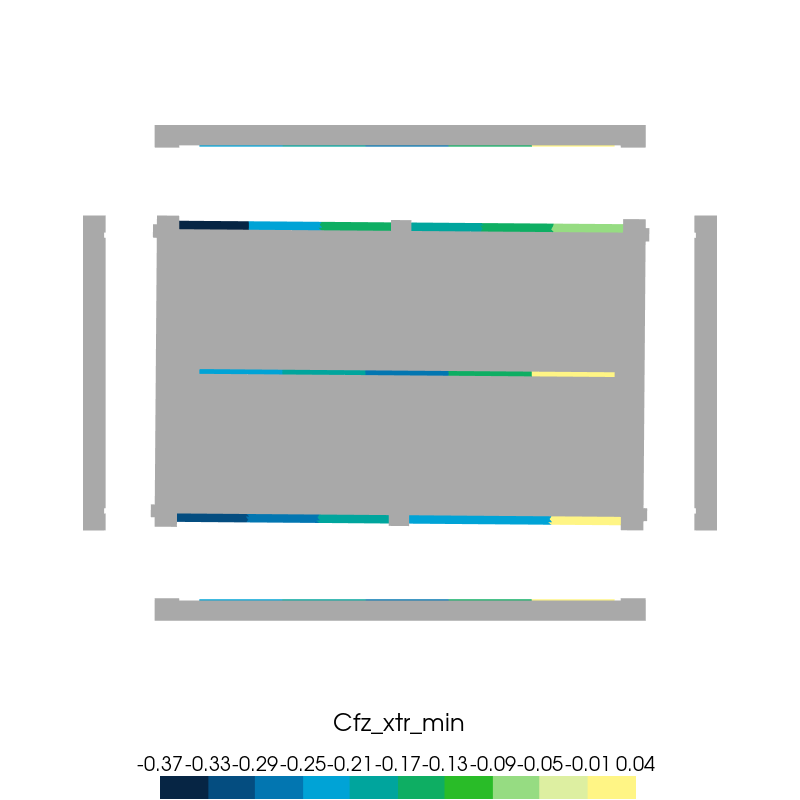

G100 283 Cf.vtp Cfz_xtr_min


/home/ubuntu/.cache/pypoetry/virtualenvs/cfdmod-7yEqALRC-py3.10/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


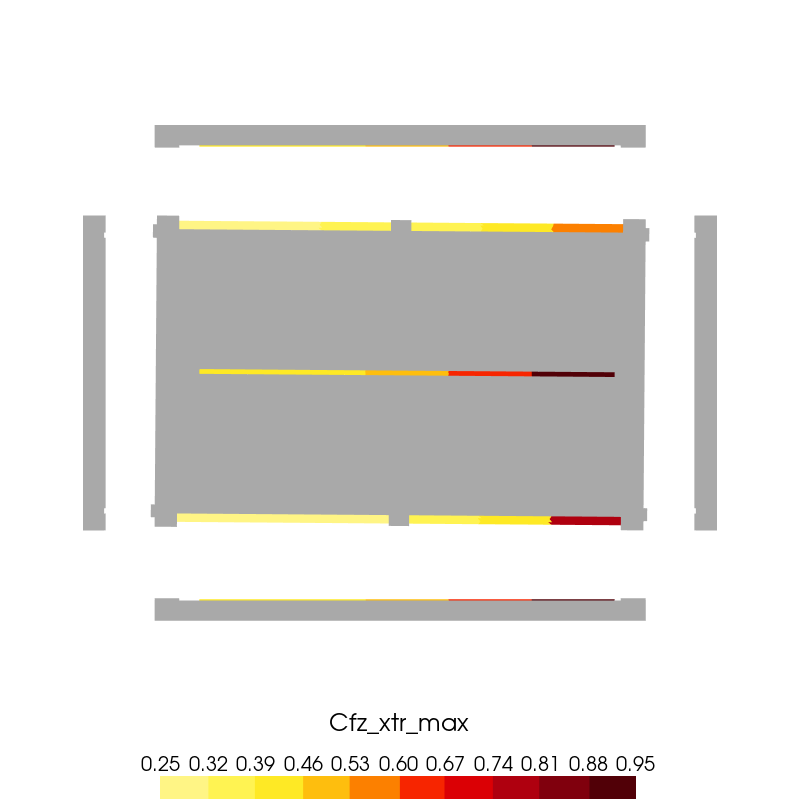

G100 283 Cf.vtp Cfz_xtr_max


/home/ubuntu/.cache/pypoetry/virtualenvs/cfdmod-7yEqALRC-py3.10/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


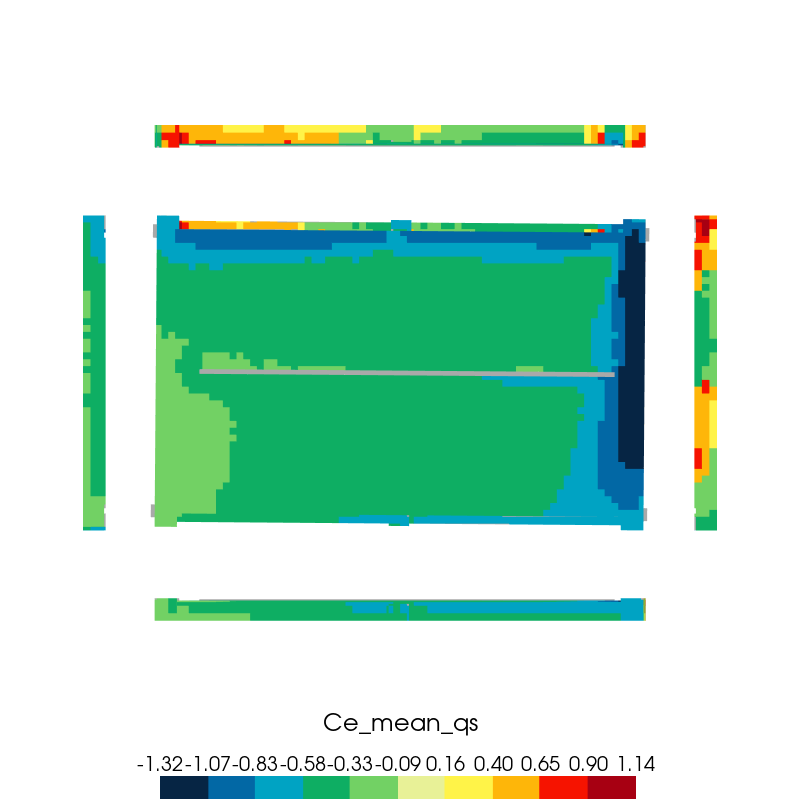

G100 328 Ce_5x5.vtp Ce_mean_qs


/home/ubuntu/.cache/pypoetry/virtualenvs/cfdmod-7yEqALRC-py3.10/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


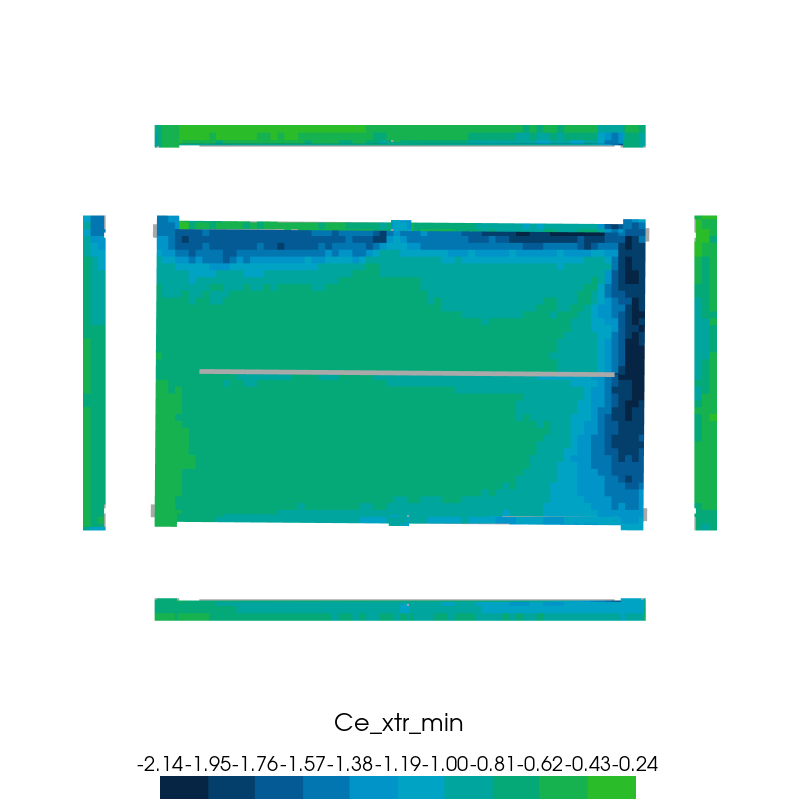

G100 328 Ce_5x5.vtp Ce_xtr_min


/home/ubuntu/.cache/pypoetry/virtualenvs/cfdmod-7yEqALRC-py3.10/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


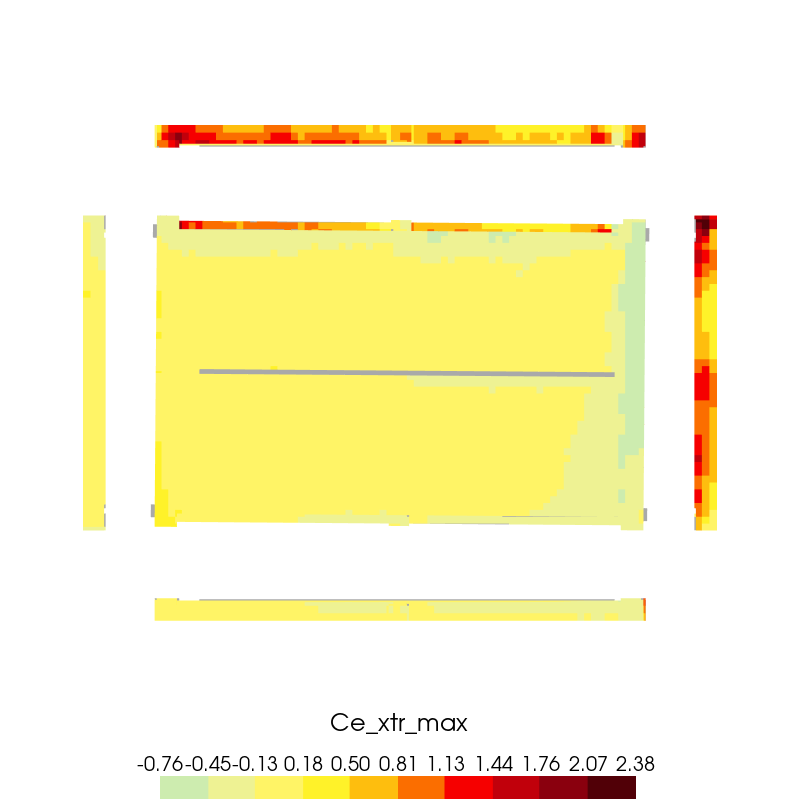

G100 328 Ce_5x5.vtp Ce_xtr_max


/home/ubuntu/.cache/pypoetry/virtualenvs/cfdmod-7yEqALRC-py3.10/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


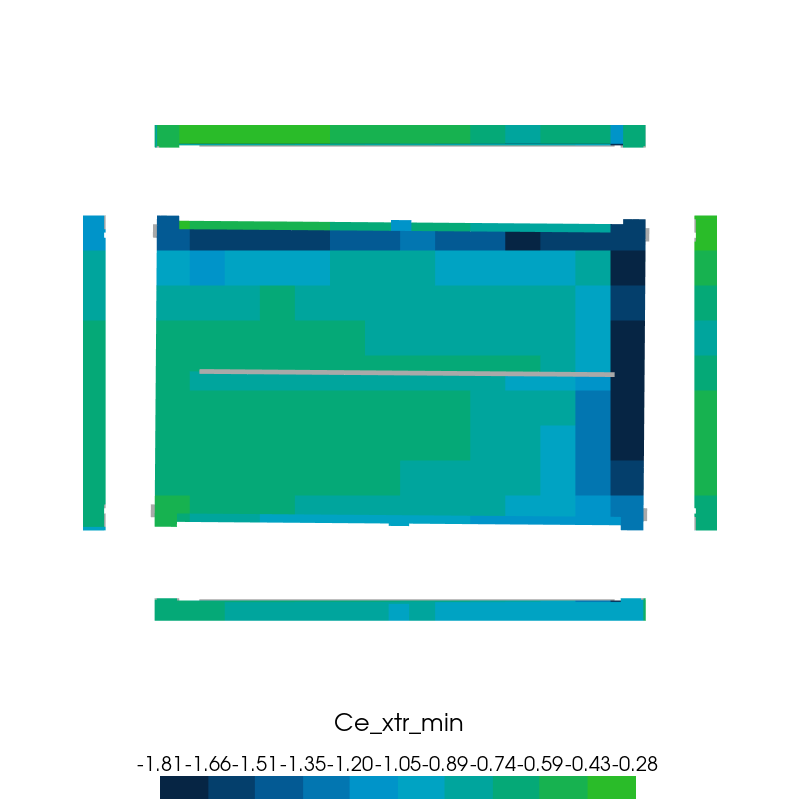

G100 328 Ce_25x25.vtp Ce_xtr_min


/home/ubuntu/.cache/pypoetry/virtualenvs/cfdmod-7yEqALRC-py3.10/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


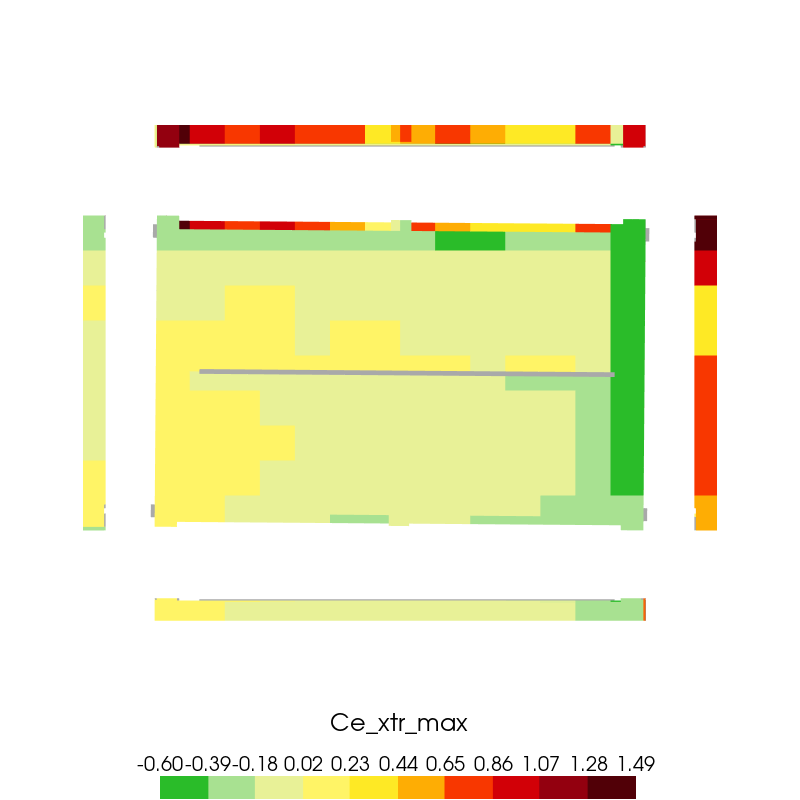

G100 328 Ce_25x25.vtp Ce_xtr_max


/home/ubuntu/.cache/pypoetry/virtualenvs/cfdmod-7yEqALRC-py3.10/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


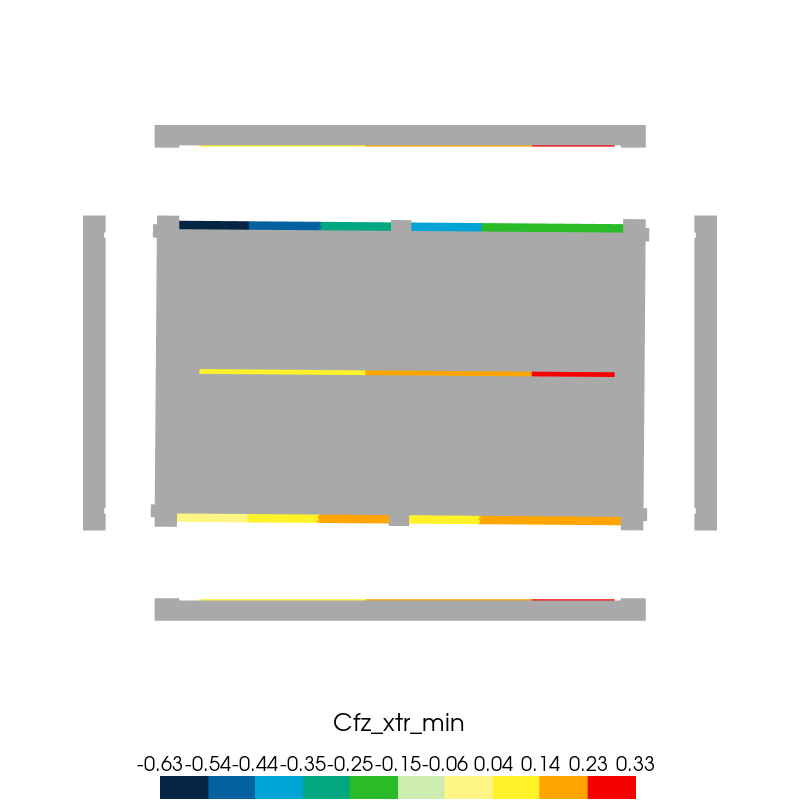

G100 328 Cf.vtp Cfz_xtr_min


/home/ubuntu/.cache/pypoetry/virtualenvs/cfdmod-7yEqALRC-py3.10/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


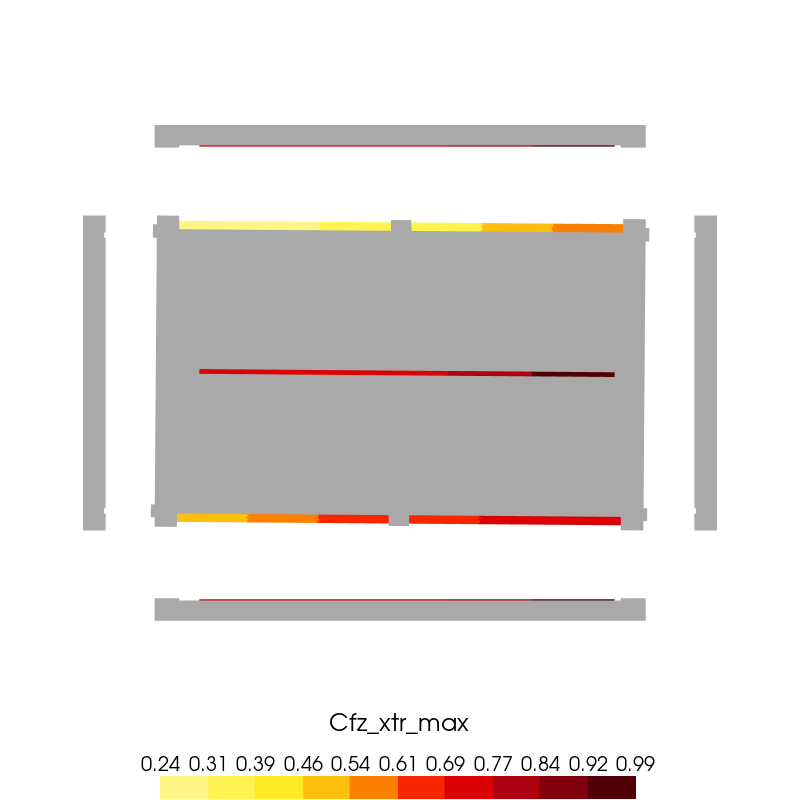

G100 328 Cf.vtp Cfz_xtr_max


In [7]:
import pyvista as pv
import numpy as np


pv.set_jupyter_backend('static')  
pv.set_plot_theme("document")

# for block_lbl in ["G200", "G300"]:
for block_lbl in ["G100"]:
    # for direction_lbl in ["000", "045", "090", "135", "180", "225", "270", "315"]:
    for direction_lbl in ["013", "058", "103", "148", "193", "238", "283", "328"]:
        for file_name, stats in file_info.items():
            file_path = f"./output/snapshot/{block_lbl}/{direction_lbl}/{file_name}"
            for scalar_name in stats:
                if scalar_name == "Ce_mean_qs":
                    scalar_lbl = "CE_MEANQS"
                elif scalar_name == "Cfz_xtr_min":
                    scalar_lbl = "CF_XTRMIN"
                elif scalar_name == "Cfz_xtr_max":
                    scalar_lbl = "CF_XTRMAX"
                elif scalar_name == "Ce_xtr_min":
                    scalar_lbl = "CE_XTRMIN"
                elif scalar_name == "Ce_xtr_max":
                    scalar_lbl = "CE_XTRMAX"
                    
                if file_name.split(".")[0] != "Cf" and scalar_name != "Ce_mean_qs":
                    suffix = file_name.split(".")[0].split("_")[1].upper()
                    # output_path = f"./output/snapshot/{scalar_name.upper()}{suffix}_{block_lbl}_{direction_lbl}.png"
                    output_path = f"./output/snapshot/{scalar_lbl}{suffix}_{block_lbl}_{direction_lbl}.png"
                else:
                    # output_path = f"./output/snapshot/{scalar_name.upper()}_{block_lbl}_{direction_lbl}.png"
                    output_path = f"./output/snapshot/{scalar_lbl}_{block_lbl}_{direction_lbl}.png"
                
                take_snapshot(var=scalar_name, file_path=file_path, block_lbl=block_lbl, output_path=output_path)

                # width_ratio = 0.8
                # height_ratio = 1
                width_ratio = 0.9
                height_ratio = 1

                cropped_image = crop_image_center(output_path, width_ratio, height_ratio)
                cropped_image.save(output_path)
                
                print(block_lbl, direction_lbl, file_name, scalar_name)